# Informations

## One script = one condition to make it easier to follow and correct.

### I am working in local for this analysis

### This script starts by taking the variant counts csv files and concatenate them together in a long df with all the reads and other informations. 

### After, with the long dataframe containing all reads for all variants it does some quality control. Then it calculates the selection coefficient. The last steps are the heatmaps and variants categorization.

#### The goal of the script is to be a linear analysis where it's easy to find information back, so it's not made to make tests. If something is wrong at any quality control step, go in another notebook to find the problem. I open other notebooks for most quality control and if there are a lot of figures to make or other things to verify.

### 1- Wide to long dataframe
### 2- Lanes control
### 3- Selection coefficient
### 4- Replicates control
### 5- Codons control
### 6- Overlaps control
### 7- Heatmaps and figures
### 8- t-test significant variants

#### I save the dataframes along the way to be able to use them elsewhere. Dataframes and figures are saved automatically with the information given at the beginning (date+experiment).

In [1]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


In [3]:
# Set up
# Here we can find all informations needed to run the script without changing code along the way. It limits errors.

##Condition

condition = "Clotrimazole" #complete name
cond = "Clotri" #abbreviation useed in the dataframes

##date + experiment

date = "2023-12-06" #date of this analysis
date_info = "2023-06-20" #date on the reads information files
year = "2023" #year on the reads count files

experiment = "NovaSeq_winter2023_albicans"

## lists

cancel_list = [92,228, 232,233,234] #positions that did not work for any reasons

stop_list = [55,89,119,139,197,238,307,370,408,466,506] #list of stop codons in the library

#positions lists

f1_f2_over = [154,155,158,162]
f2_f3_over = [276,277,280] #275 was supposed to be there, but it's cut because of the primer
f3_f4_over = [401,402,403,404,405,406] #407 was supposed to be there, but it's cut because of the primer

over_list = [154,155,158,162,276,277,280,401,402,403,404,405,406] #all overlap

#codons

Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

DNA_Codons = {"GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A","TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D","GAA": "E", "GAG": "E","TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G","CAT": "H", "CAC": "H","ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K", "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M","AAT": "N", "AAC": "N","CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P","CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R","TCT": "S", "TCC": "S", "TCA": "S", 
    "TCG": "S", "AGT": "S", "AGC": "S","ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V","TGG": "W","TAT": "Y", "TAC": "Y","TAA": "*", "TAG": "*", "TGA": "*"}

In [4]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

# 1- Wide to long dataframe

In [5]:
##taked all variant counts csv files to have a long df

##sorry this is the most horrible function I ever made (but somehow it works)

def wide_to_long(path_vari, path_info):
    
    df_info = pd.read_excel(path_info, header=0)
    df_info = df_info.sort_values(by='Name', ignore_index=True)
    
    files = [os.path.join(path_vari, i) for i in os.listdir(path_vari) if os.path.isfile(os.path.join(path_vari, i))]
    
    name_list = []
    
    # Get a list of the files names
    for name in files:
        file_name = os.path.splitext(os.path.basename(name))[0]
        name_list.append(file_name)
    
    dict_df = {}
    
    # For every file in the folder, read it and append to an empty dict
    for i in range(len(files)):
        print(str(files[i]))
        df = pd.read_csv(files[i], index_col=0)
        dict_df[name_list[i]] = df
        
    dict_melt = {}
    
    # Variants df wide to long
    for key in dict_df:
        df_reads = dict_df[key]
        dfm = df_reads.melt(ignore_index=False).reset_index()
        dfm = dfm.rename(columns={"index": "codon", "variable": "position", "value": "nbr_reads"})
        dict_melt[key] = dfm
        
    dict_df_long = {}
    inter = 0
    
    # Add the info in the long df
    for key in dict_melt:
        info = df_info

        times = len(dict_melt[key])
        con = info.iloc[inter, 3]
        tp = info.iloc[inter, 5]
        ant = info.iloc[inter, 6]
        frag = info.iloc[inter, 7]
        rep = info.iloc[inter, 8]
        la = info.iloc[inter, 9]
        OD = info.iloc[inter, 10]
        want = info.iloc[inter, 11]
        beef = info.iloc[inter, 12]
        afme = info.iloc[inter, 14]
        single = info.iloc[inter, 19]
        align = info.iloc[inter, 21]
        wt = info.iloc[inter, 22]

        chunk = pd.DataFrame({'Condition': [con], 'Timepoint': [tp], "Antifungal": [ant], "Fragment": [frag],
                              "Replicate": [rep], "Lane": [la], "OD": [OD], "reads_wanted": [want], "reads_before": [beef],
                              "reads_after_merge": [afme], "nbr_reads_single": [single], "reads_align": [align],
                              "reads_wt": [wt]})

        lala = chunk.loc[chunk.index.repeat(times)]
        lolilol = lala.reset_index()

        yay = pd.concat([dict_melt[key], lolilol], axis=1)
        print(yay)
        dict_df_long[key] = yay

        inter += 1
        
    df_list = list(dict_df_long.values())
    df_big = {}

    # Concatenate everybody together
    for i in range(len(df_list)):

        if i == 0:

            s1 = df_list[i]
            s2 = df_list[i + 1]
            df_big = pd.concat([s1, s2])
        
        elif i < len(df_list) and i != 0 and not i >= len(df_list) - 1:

            s1 = df_list[i + 1]
            df_big = pd.concat([df_big, s1], axis=0, ignore_index=True)
        
        else:
            print("The end")
        
    return df_big

In [6]:
F4_long = wide_to_long('../Variants Count/Fragment 4/',f"../Reads_info/Reads_count_CaERG11-F4_all.xlsx")
F3_long = wide_to_long('../Variants Count/Fragment 3/',f"../Reads_info/Reads_count_CaERG11-F3_all.xlsx")
F2_long = wide_to_long('../Variants Count/Fragment 2/',f"../Reads_info/Reads_count_CaERG11-F2_all.xlsx")
F1_long = wide_to_long('../Variants Count/Fragment 1/',f"../Reads_info/Reads_count_CaERG11-F1_all.xlsx")

F1_2_long = pd.concat([F1_long,F2_long],axis=0)
F3_4_long = pd.concat([F3_long, F4_long],axis=0)
All_long = pd.concat([F1_2_long, F3_4_long],axis=0)

All_long.to_csv(f'Long_df_variants_reads_final_{date}.csv')  

All_long

../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_1_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_2_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_3_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_C_2023-06-20.cs

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      401       21.0      0  CaERG11_2_Clotri_F4_A          2   
1      GCC      401        8.0      0  CaERG11_2_Clotri_F4_A          2   
2      TGC      401       66.0      0  CaERG11_2_Clotri_F4_A          2   
3      TGT      401       36.0      0  CaERG11_2_Clotri_F4_A          2   
4      GAT      401        8.0      0  CaERG11_2_Clotri_F4_A          2   
...    ...      ...        ...    ...                    ...        ...   
2062   GTC      511      303.0      0  CaERG11_2_Clotri_F4_A          2   
2063   TGG      511      423.0      0  CaERG11_2_Clotri_F4_A          2   
2064   TAC      511       25.0      0  CaERG11_2_Clotri_F4_A          2   
2065   TAT      511       27.0      0  CaERG11_2_Clotri_F4_A          2   
2066   TAA      511        NaN      0  CaERG11_2_Clotri_F4_A          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Clotri       F4       

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      401      534.0      0  CaERG11_3_None_F4_1          3   
1      GCC      401      282.0      0  CaERG11_3_None_F4_1          3   
2      TGC      401      343.0      0  CaERG11_3_None_F4_1          3   
3      TGT      401      460.0      0  CaERG11_3_None_F4_1          3   
4      GAT      401      217.0      0  CaERG11_3_None_F4_1          3   
...    ...      ...        ...    ...                  ...        ...   
2062   GTC      511      283.0      0  CaERG11_3_None_F4_1          3   
2063   TGG      511      305.0      0  CaERG11_3_None_F4_1          3   
2064   TAC      511      320.0      0  CaERG11_3_None_F4_1          3   
2065   TAT      511      209.0      0  CaERG11_3_None_F4_1          3   
2066   TAA      511        NaN      0  CaERG11_3_None_F4_1          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F4          1  L001  8.667466   

The end
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_C_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_c

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      276      156.0      0  CaERG11_0_None_F3_2          0   
1      GCC      276      218.0      0  CaERG11_0_None_F3_2          0   
2      TGC      276      308.0      0  CaERG11_0_None_F3_2          0   
3      TGT      276      149.0      0  CaERG11_0_None_F3_2          0   
4      GAT      276      177.0      0  CaERG11_0_None_F3_2          0   
...    ...      ...        ...    ...                  ...        ...   
2101   GTC      406      257.0      0  CaERG11_0_None_F3_2          0   
2102   TGG      406      191.0      0  CaERG11_0_None_F3_2          0   
2103   TAC      406      404.0      0  CaERG11_0_None_F3_2          0   
2104   TAT      406      215.0      0  CaERG11_0_None_F3_2          0   
2105   TAA      406        NaN      0  CaERG11_0_None_F3_2          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0          None       F3          2  L002  7

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT      276       14.0      0  CaERG11_2_Fluco_F3_1          2   
1      GCC      276       34.0      0  CaERG11_2_Fluco_F3_1          2   
2      TGC      276       31.0      0  CaERG11_2_Fluco_F3_1          2   
3      TGT      276       33.0      0  CaERG11_2_Fluco_F3_1          2   
4      GAT      276      624.0      0  CaERG11_2_Fluco_F3_1          2   
...    ...      ...        ...    ...                   ...        ...   
2101   GTC      406      464.0      0  CaERG11_2_Fluco_F3_1          2   
2102   TGG      406      162.0      0  CaERG11_2_Fluco_F3_1          2   
2103   TAC      406     1590.0      0  CaERG11_2_Fluco_F3_1          2   
2104   TAT      406      745.0      0  CaERG11_2_Fluco_F3_1          2   
2105   TAA      406        NaN      0  CaERG11_2_Fluco_F3_1          2   

     Antifungal Fragment  Replicate  Lane       OD  reads_wanted  \
0         Fluco       F3          1  L002  

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      276       12.0      0  CaERG11_2_Posaco_F3_B          2   
1      GCC      276       35.0      0  CaERG11_2_Posaco_F3_B          2   
2      TGC      276       37.0      0  CaERG11_2_Posaco_F3_B          2   
3      TGT      276       38.0      0  CaERG11_2_Posaco_F3_B          2   
4      GAT      276      664.0      0  CaERG11_2_Posaco_F3_B          2   
...    ...      ...        ...    ...                    ...        ...   
2101   GTC      406      186.0      0  CaERG11_2_Posaco_F3_B          2   
2102   TGG      406       31.0      0  CaERG11_2_Posaco_F3_B          2   
2103   TAC      406      490.0      0  CaERG11_2_Posaco_F3_B          2   
2104   TAT      406      205.0      0  CaERG11_2_Posaco_F3_B          2   
2105   TAA      406        NaN      0  CaERG11_2_Posaco_F3_B          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Posaco       F3       

The end
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_C_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_c

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT      154      285.0      0  CaERG11_0_Fluco_F2_3          0   
1      GCC      154      354.0      0  CaERG11_0_Fluco_F2_3          0   
2      TGC      154      513.0      0  CaERG11_0_Fluco_F2_3          0   
3      TGT      154      333.0      0  CaERG11_0_Fluco_F2_3          0   
4      GAT      154      692.0      0  CaERG11_0_Fluco_F2_3          0   
...    ...      ...        ...    ...                   ...        ...   
1360   GTC      280      552.0      0  CaERG11_0_Fluco_F2_3          0   
1361   TGG      280      544.0      0  CaERG11_0_Fluco_F2_3          0   
1362   TAC      280      359.0      0  CaERG11_0_Fluco_F2_3          0   
1363   TAT      280      297.0      0  CaERG11_0_Fluco_F2_3          0   
1364   TAA      280        1.0      0  CaERG11_0_Fluco_F2_3          0   

     Antifungal Fragment  Replicate  Lane   OD  reads_wanted  reads_before  \
0         Fluco       F2         

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT      154      612.0      0  CaERG11_2_Fluco_F2_1          2   
1      GCC      154     1047.0      0  CaERG11_2_Fluco_F2_1          2   
2      TGC      154     1085.0      0  CaERG11_2_Fluco_F2_1          2   
3      TGT      154      717.0      0  CaERG11_2_Fluco_F2_1          2   
4      GAT      154       97.0      0  CaERG11_2_Fluco_F2_1          2   
...    ...      ...        ...    ...                   ...        ...   
1360   GTC      280       28.0      0  CaERG11_2_Fluco_F2_1          2   
1361   TGG      280      805.0      0  CaERG11_2_Fluco_F2_1          2   
1362   TAC      280        9.0      0  CaERG11_2_Fluco_F2_1          2   
1363   TAT      280        6.0      0  CaERG11_2_Fluco_F2_1          2   
1364   TAA      280        NaN      0  CaERG11_2_Fluco_F2_1          2   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0         Fluco       F2          1  L001 

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      154      345.0      0  CaERG11_3_None_F2_2          3   
1      GCC      154      512.0      0  CaERG11_3_None_F2_2          3   
2      TGC      154      768.0      0  CaERG11_3_None_F2_2          3   
3      TGT      154      448.0      0  CaERG11_3_None_F2_2          3   
4      GAT      154      880.0      0  CaERG11_3_None_F2_2          3   
...    ...      ...        ...    ...                  ...        ...   
1360   GTC      280      682.0      0  CaERG11_3_None_F2_2          3   
1361   TGG      280      647.0      0  CaERG11_3_None_F2_2          3   
1362   TAC      280      443.0      0  CaERG11_3_None_F2_2          3   
1363   TAT      280      342.0      0  CaERG11_3_None_F2_2          3   
1364   TAA      280        NaN      0  CaERG11_3_None_F2_2          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F2          2  L001  8.173127   

The end
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_C_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_c

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT       55      515.0      0  CaERG11_0_None_F1_2          0   
1      GCC       55      317.0      0  CaERG11_0_None_F1_2          0   
2      TGC       55      485.0      0  CaERG11_0_None_F1_2          0   
3      TGT       55      595.0      0  CaERG11_0_None_F1_2          0   
4      GAT       55      594.0      0  CaERG11_0_None_F1_2          0   
...    ...      ...        ...    ...                  ...        ...   
2998   GTC      162      371.0      0  CaERG11_0_None_F1_2          0   
2999   TGG      162      644.0      0  CaERG11_0_None_F1_2          0   
3000   TAC      162      547.0      0  CaERG11_0_None_F1_2          0   
3001   TAT      162      625.0      0  CaERG11_0_None_F1_2          0   
3002   TAA      162        NaN      0  CaERG11_0_None_F1_2          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0          None       F1          2  L001  8

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT       55      189.0      0  CaERG11_2_Fluco_F1_1          2   
1      GCC       55      129.0      0  CaERG11_2_Fluco_F1_1          2   
2      TGC       55      199.0      0  CaERG11_2_Fluco_F1_1          2   
3      TGT       55      293.0      0  CaERG11_2_Fluco_F1_1          2   
4      GAT       55       13.0      0  CaERG11_2_Fluco_F1_1          2   
...    ...      ...        ...    ...                   ...        ...   
2998   GTC      162      137.0      0  CaERG11_2_Fluco_F1_1          2   
2999   TGG      162      314.0      0  CaERG11_2_Fluco_F1_1          2   
3000   TAC      162      332.0      0  CaERG11_2_Fluco_F1_1          2   
3001   TAT      162      364.0      0  CaERG11_2_Fluco_F1_1          2   
3002   TAA      162        NaN      0  CaERG11_2_Fluco_F1_1          2   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0         Fluco       F1          1  L001 

The end


codon position  nbr_reads  index              Condition  Timepoint  \
0       GCT       55      528.0      0  CaERG11_0_Clotri_F1_A          0   
1       GCC       55      386.0      0  CaERG11_0_Clotri_F1_A          0   
2       TGC       55      532.0      0  CaERG11_0_Clotri_F1_A          0   
3       TGT       55      601.0      0  CaERG11_0_Clotri_F1_A          0   
4       GAT       55      628.0      0  CaERG11_0_Clotri_F1_A          0   
...     ...      ...        ...    ...                    ...        ...   
99211   GTC      511      235.0      0    CaERG11_3_None_F4_3          3   
99212   TGG      511      293.0      0    CaERG11_3_None_F4_3          3   
99213   TAC      511      360.0      0    CaERG11_3_None_F4_3          3   
99214   TAT      511      198.0      0    CaERG11_3_None_F4_3          3   
99215   TAA      511        1.0      0    CaERG11_3_None_F4_3          3   

      Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0         Clotri       F1         A  L001  0.000000       5000000   
1         Clotri       F1         A  L001  0.000000       5000000   
2         Clotri       F1         A  L001  0.000000       5000000   
3         Clotri       F1         A  L001  0.000000       5000000   
4         Clotri       F1         A  L001  0.000000       5000000   
...          ...      ...       ...   ...       ...           ...   
99211       None       F4         3  L002  8.291309       2500000   
99212       None       F4         3  L002  8.291309       2500000   
99213       None       F4         3  L002  8.291309       2500000   
99214       None       F4         3  L002  8.291309       2500000   
99215       None       F4         3  L002  8.291309       2500000   

       reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0           5286093            4989961           1113525      4954935   
1           5286093            4989961           1113525      4954935   
2           5286093            4989961           1113525      4954935   
3           5286093            4989961           1113525      4954935   
4           5286093            4989961           1113525      4954935   
...             ...                ...               ...          ...   
99211       1657998            1625552            449165      1596281   
99212       1657998            1625552            449165      1596281   
99213       1657998            1625552            449165      1596281   
99214       1657998            1625552            449165      1596281   
99215       1657998            1625552            449165      1596281   

       reads_wt  
0        444237  
1        444237  
2        444237  
3        444237  
4        444237  
...         ...  
99211    216412  
99212    216412  
99213    216412  
99214    216412  
99215    216412  

[448812 rows x 17 columns]

# 2- Control between lanes

In [7]:
#import the long df with all variants reads

df = pd.read_csv(f'Long_df_variants_reads_final_{date}.csv', header=0, index_col = 0)
df = df.drop("index",axis=1)
df = df.reset_index()
df = df.drop("index",axis=1)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   
448811   TAA       511        1.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   
448811       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   
448811       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448807    216412  
448808    216412  
448809    216412  
448810    216412  
448811    216412  

[448812 rows x 16 columns]

In [8]:
#remove all positions that did not worked for any reason and that are stops not in the library
#takes like 1 minute

to_drop = []

for index, row in df.iterrows():
    if row["position"] in cancel_list:
        to_drop.append(index)
    elif row['position'] not in stop_list and row["codon"] == "TAA":
        to_drop.append(index)

df = df.drop(to_drop)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448806   GTT       511      197.0    CaERG11_3_None_F4_3          3   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448806       None       F4         3  L002  8.291309       2500000   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448806       1657998            1625552            449165      1596281   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448806    216412  
448807    216412  
448808    216412  
448809    216412  
448810    216412  

[427620 rows x 16 columns]

In [9]:
#keep only rows with the condition your analysing

df_anti = df.groupby("Antifungal")
df = df_anti.get_group(cond)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
405399   GTT       511      351.0  CaERG11_2_Clotri_F4_C          2   
405400   GTC       511      510.0  CaERG11_2_Clotri_F4_C          2   
405401   TGG       511      854.0  CaERG11_2_Clotri_F4_C          2   
405402   TAC       511       63.0  CaERG11_2_Clotri_F4_C          2   
405403   TAT       511       85.0  CaERG11_2_Clotri_F4_C          2   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
405399     Clotri       F4         C  L001  8.644147       5000000   
405400     Clotri       F4         C  L001  8.644147       5000000   
405401     Clotri       F4         C  L001  8.644147       5000000   
405402     Clotri       F4         C  L001  8.644147       5000000   
405403     Clotri       F4         C  L001  8.644147       5000000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
405399       4809170            4792814           1206529      4735257   
405400       4809170            4792814           1206529      4735257   
405401       4809170            4792814           1206529      4735257   
405402       4809170            4792814           1206529      4735257   
405403       4809170            4792814           1206529      4735257   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
405399    389568  
405400    389568  
405401    389568  
405402    389568  
405403    389568  

[48858 rows x 16 columns]

In [10]:
#If it looks good we can Sum the lanes

df_group = df.groupby(["Condition","position","codon","Timepoint","Antifungal","Fragment", "Replicate", "OD"])
cols = ["nbr_reads","reads_wanted","reads_before",
        "reads_after_merge","nbr_reads_single", "reads_align","reads_wt"]
df_sum = df_group[cols].sum()

#reset index so the index becomes columns again
df_sum = df_sum.reset_index(level=["Condition","position","codon",
                                   "Timepoint","Antifungal","Fragment", "Replicate","OD"])

df_sum

Condition  position codon  Timepoint Antifungal Fragment  \
0      CaERG11_0_Clotri_F1_A        55   AAA          0     Clotri       F1   
1      CaERG11_0_Clotri_F1_A        55   AAC          0     Clotri       F1   
2      CaERG11_0_Clotri_F1_A        55   AAG          0     Clotri       F1   
3      CaERG11_0_Clotri_F1_A        55   AAT          0     Clotri       F1   
4      CaERG11_0_Clotri_F1_A        55   ACC          0     Clotri       F1   
...                      ...       ...   ...        ...        ...      ...   
48853  CaERG11_2_Clotri_F4_C       511   TGT          2     Clotri       F4   
48854  CaERG11_2_Clotri_F4_C       511   TTA          2     Clotri       F4   
48855  CaERG11_2_Clotri_F4_C       511   TTC          2     Clotri       F4   
48856  CaERG11_2_Clotri_F4_C       511   TTG          2     Clotri       F4   
48857  CaERG11_2_Clotri_F4_C       511   TTT          2     Clotri       F4   

      Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0             A  0.000000      508.0       5000000       5286093   
1             A  0.000000      406.0       5000000       5286093   
2             A  0.000000      598.0       5000000       5286093   
3             A  0.000000      370.0       5000000       5286093   
4             A  0.000000      267.0       5000000       5286093   
...         ...       ...        ...           ...           ...   
48853         C  8.644147      656.0       5000000       4809170   
48854         C  8.644147      359.0       5000000       4809170   
48855         C  8.644147     3787.0       5000000       4809170   
48856         C  8.644147      472.0       5000000       4809170   
48857         C  8.644147     4326.0       5000000       4809170   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                4989961           1113525      4954935    444237  
1                4989961           1113525      4954935    444237  
2                4989961           1113525      4954935    444237  
3                4989961           1113525      4954935    444237  
4                4989961           1113525      4954935    444237  
...                  ...               ...          ...       ...  
48853            4792814           1206529      4735257    389568  
48854            4792814           1206529      4735257    389568  
48855            4792814           1206529      4735257    389568  
48856            4792814           1206529      4735257    389568  
48857            4792814           1206529      4735257    389568  

[48858 rows x 15 columns]

C:\Users\CABED117\Anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


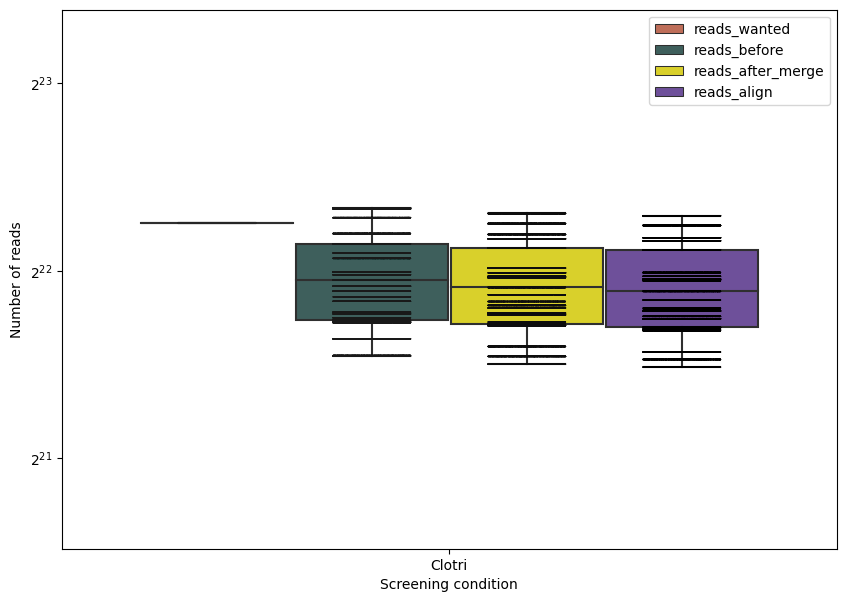

In [11]:
df_melt = pd.melt(df_sum, id_vars=['Antifungal'],value_vars=['reads_wanted', "reads_before",'reads_after_merge',"reads_align"], var_name='Reads control', value_name='Reads')

plt.figure(figsize=(10, 7))
custom_palette = sns.blend_palette(["#CF6448","#386461","#F6EA0E","#6C44A6"], n_colors=4)

ax = sns.boxplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",palette = custom_palette)
ax = sns.stripplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",color="black",dodge=True, jitter=0.2, size=1)

plt.ylim(1500000, 11000000)

plt.yscale('log', base=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4])

plt.xlabel('Screening condition')
plt.ylabel('Number of reads')

plt.show()

In [12]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [13]:
# remove wt, they have a count of 0 as they are not variants

ite = 0

for i in df_sum.iterrows() :
    
    first_row = df_sum.loc[ite]
    
    position = first_row['position']
    codon_wt = wt_dict[position]
    
    if first_row['codon'] == codon_wt :

        df_sum = df_sum.drop(ite)
        
    ite = ite+1   
    
df_sum = df_sum.reset_index()
df_sum

index              Condition  position codon  Timepoint Antifungal  \
0          0  CaERG11_0_Clotri_F1_A        55   AAA          0     Clotri   
1          1  CaERG11_0_Clotri_F1_A        55   AAC          0     Clotri   
2          2  CaERG11_0_Clotri_F1_A        55   AAG          0     Clotri   
3          3  CaERG11_0_Clotri_F1_A        55   AAT          0     Clotri   
4          4  CaERG11_0_Clotri_F1_A        55   ACC          0     Clotri   
...      ...                    ...       ...   ...        ...        ...   
47947  48853  CaERG11_2_Clotri_F4_C       511   TGT          2     Clotri   
47948  48854  CaERG11_2_Clotri_F4_C       511   TTA          2     Clotri   
47949  48855  CaERG11_2_Clotri_F4_C       511   TTC          2     Clotri   
47950  48856  CaERG11_2_Clotri_F4_C       511   TTG          2     Clotri   
47951  48857  CaERG11_2_Clotri_F4_C       511   TTT          2     Clotri   

      Fragment Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A  0.000000      508.0       5000000       5286093   
1           F1         A  0.000000      406.0       5000000       5286093   
2           F1         A  0.000000      598.0       5000000       5286093   
3           F1         A  0.000000      370.0       5000000       5286093   
4           F1         A  0.000000      267.0       5000000       5286093   
...        ...       ...       ...        ...           ...           ...   
47947       F4         C  8.644147      656.0       5000000       4809170   
47948       F4         C  8.644147      359.0       5000000       4809170   
47949       F4         C  8.644147     3787.0       5000000       4809170   
47950       F4         C  8.644147      472.0       5000000       4809170   
47951       F4         C  8.644147     4326.0       5000000       4809170   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                4989961           1113525      4954935    444237  
1                4989961           1113525      4954935    444237  
2                4989961           1113525      4954935    444237  
3                4989961           1113525      4954935    444237  
4                4989961           1113525      4954935    444237  
...                  ...               ...          ...       ...  
47947            4792814           1206529      4735257    389568  
47948            4792814           1206529      4735257    389568  
47949            4792814           1206529      4735257    389568  
47950            4792814           1206529      4735257    389568  
47951            4792814           1206529      4735257    389568  

[47952 rows x 16 columns]

In [14]:
#Now we summed the lanes we can put more info in the df : reads in log and normalized. 
#You have to add +1 to the number of reads if you want to be able to get the log2

df_sum['nbr_reads_log'] = np.log2(df_sum['nbr_reads']+1)
df_sum['norm_reads'] = ((df_sum['nbr_reads']+1) / df_sum['reads_align'])
df_sum['norm_reads_log'] = np.log2(df_sum['norm_reads'])

df_sum=df_sum.reset_index()
df_sum = df_sum.drop("index",axis=1)

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date
df_sum.to_csv(f"c:{name}.csv")  

# 3- Selection coefficient

In [15]:
#open the variants counts with summed lanes

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
df_v = pd.read_csv(name, header=0, index_col = 0)
df_v

level_0              Condition  position codon  Timepoint Antifungal  \
0            0  CaERG11_0_Clotri_F1_A        55   AAA          0     Clotri   
1            1  CaERG11_0_Clotri_F1_A        55   AAC          0     Clotri   
2            2  CaERG11_0_Clotri_F1_A        55   AAG          0     Clotri   
3            3  CaERG11_0_Clotri_F1_A        55   AAT          0     Clotri   
4            4  CaERG11_0_Clotri_F1_A        55   ACC          0     Clotri   
...        ...                    ...       ...   ...        ...        ...   
47947    47947  CaERG11_2_Clotri_F4_C       511   TGT          2     Clotri   
47948    47948  CaERG11_2_Clotri_F4_C       511   TTA          2     Clotri   
47949    47949  CaERG11_2_Clotri_F4_C       511   TTC          2     Clotri   
47950    47950  CaERG11_2_Clotri_F4_C       511   TTG          2     Clotri   
47951    47951  CaERG11_2_Clotri_F4_C       511   TTT          2     Clotri   

      Fragment Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A  0.000000      508.0       5000000       5286093   
1           F1         A  0.000000      406.0       5000000       5286093   
2           F1         A  0.000000      598.0       5000000       5286093   
3           F1         A  0.000000      370.0       5000000       5286093   
4           F1         A  0.000000      267.0       5000000       5286093   
...        ...       ...       ...        ...           ...           ...   
47947       F4         C  8.644147      656.0       5000000       4809170   
47948       F4         C  8.644147      359.0       5000000       4809170   
47949       F4         C  8.644147     3787.0       5000000       4809170   
47950       F4         C  8.644147      472.0       5000000       4809170   
47951       F4         C  8.644147     4326.0       5000000       4809170   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  \
0                4989961           1113525      4954935    444237   
1                4989961           1113525      4954935    444237   
2                4989961           1113525      4954935    444237   
3                4989961           1113525      4954935    444237   
4                4989961           1113525      4954935    444237   
...                  ...               ...          ...       ...   
47947            4792814           1206529      4735257    389568   
47948            4792814           1206529      4735257    389568   
47949            4792814           1206529      4735257    389568   
47950            4792814           1206529      4735257    389568   
47951            4792814           1206529      4735257    389568   

       nbr_reads_log  norm_reads  norm_reads_log  
0           8.991522    0.000103      -13.248913  
1           8.668885    0.000082      -13.571550  
2           9.226412    0.000121      -13.014023  
3           8.535275    0.000075      -13.705159  
4           8.066089    0.000054      -14.174346  
...              ...         ...             ...  
47947       9.359750    0.000139      -12.815262  
47948       8.491853    0.000076      -13.683158  
47949      11.887221    0.000800      -10.287791  
47950       8.885696    0.000100      -13.289315  
47951      12.079151    0.000914      -10.095860  

[47952 rows x 19 columns]

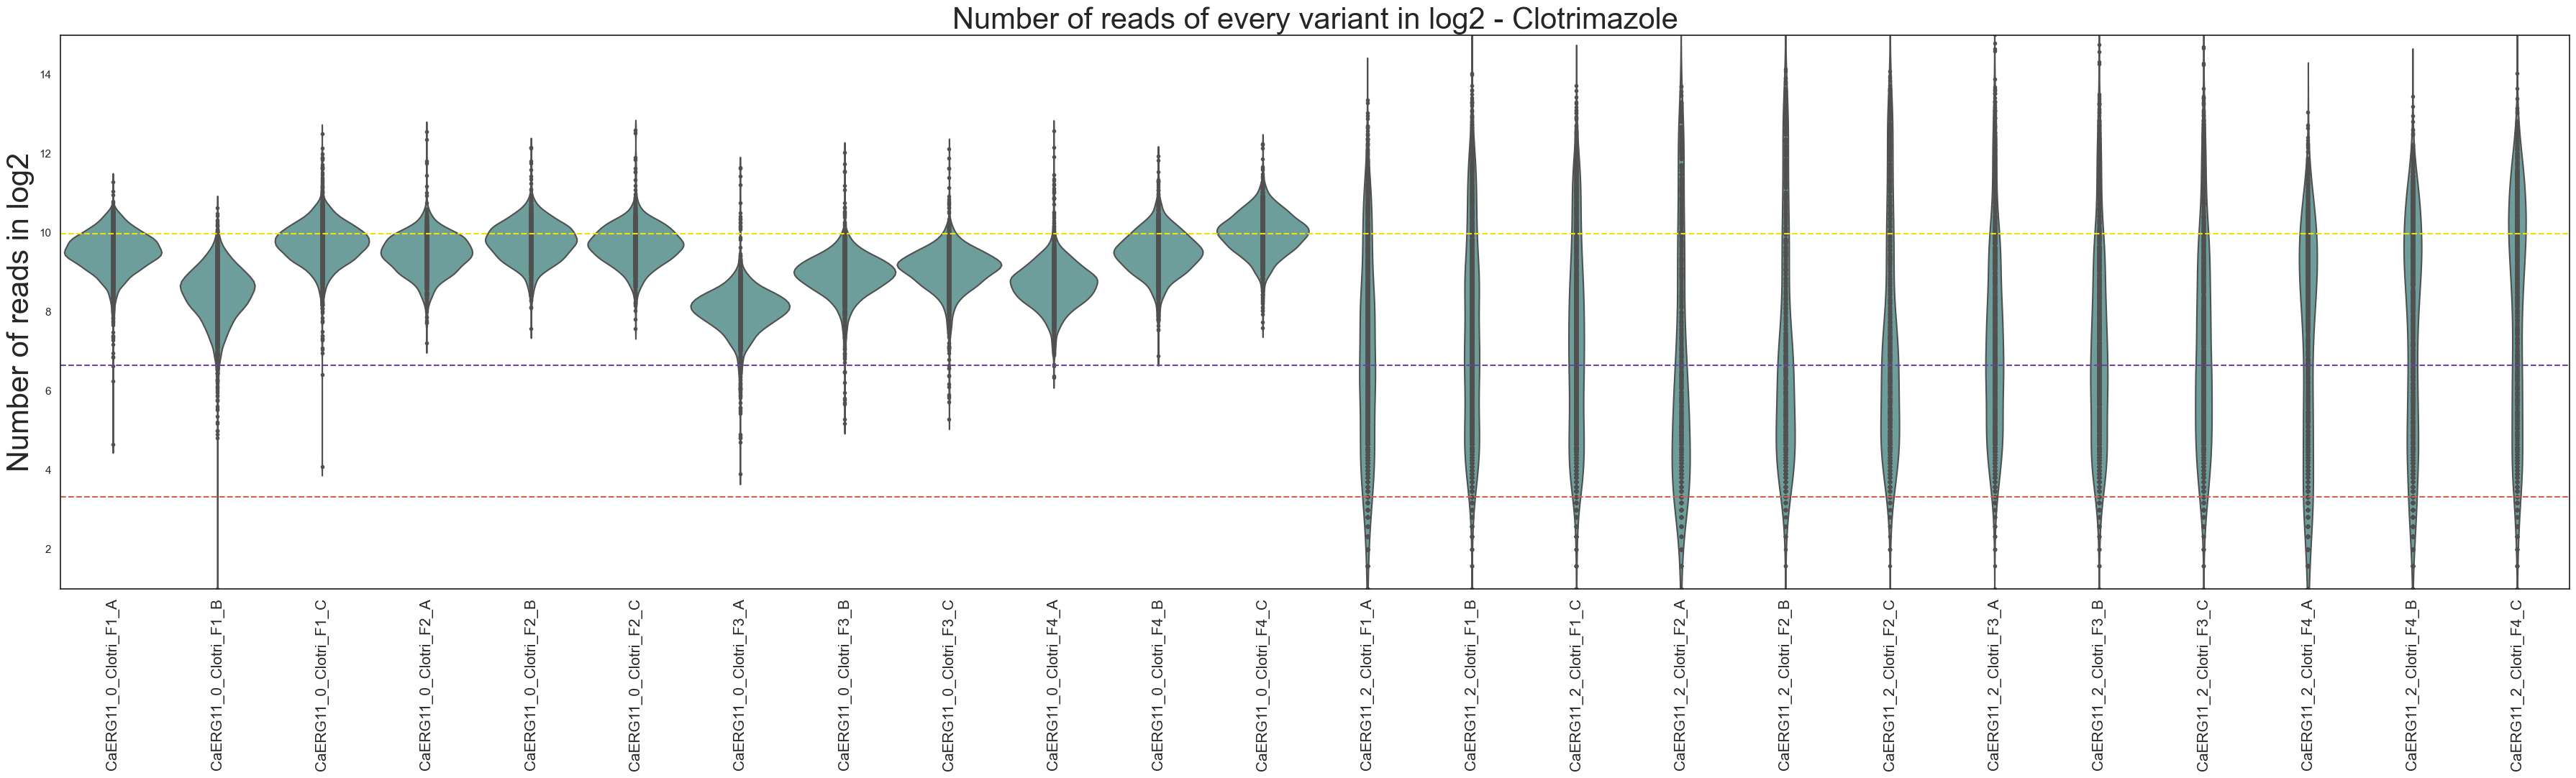

In [16]:

sns.set_style("white")

row = 0
sns.set_theme(style="white", palette=None)
plt.figure(figsize=(45,10))

sns.violinplot(data = df_v, x = 'Condition', y = 'nbr_reads_log',  inner = "point",width=1, color = "#65A6A2")
plt.ylabel("Number of reads in log2",fontsize = 30)
plt.xlabel("")
plt.tick_params(axis="x", labelsize=15, rotation = 90) 
title = condition
plt.title(title, fontsize = 40)
plt.axhline(9.97, color="#EEE304", linestyle="--")
plt.axhline(6.64, color = "#6C44A6", linestyle="--")
plt.axhline(3.32, color = "#D06448", linestyle="--")
plt.ylim(1, 15)


plt.title(f'Number of reads of every variant in log2 - {condition}',y=1, fontsize=30)

name = "./violin_plot_reads_all_log2_lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
plt.savefig(f'{name}.png', transparent=True, dpi=400, bbox_inches='tight')

In [17]:
#Get a wide format with reads at every timepoint

#reads norm not in log
df_wide_tp = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"], 
                            columns= "Timepoint", values="norm_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tp=df_wide_tp[colus]

df_wide_tp = df_wide_tp.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tp = df_wide_tp.rename(columns={0: 'freq_tp0', 1 : "freq_tp1",
                                        2 : "freq_tp2", 3 : "freq_tp3"}) #remove 3 if no tp3

df_wide_tp

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2
0                55   AAA     Clotri       F1         A  0.000103  0.000003
1                55   AAA     Clotri       F1         B  0.000052  0.000004
2                55   AAA     Clotri       F1         C  0.000146  0.000009
3                55   AAC     Clotri       F1         A  0.000082  0.000006
4                55   AAC     Clotri       F1         B  0.000069  0.000010
...             ...   ...        ...      ...       ...       ...       ...
23971           511   TTG     Clotri       F4         B  0.000182  0.000096
23972           511   TTG     Clotri       F4         C  0.000218  0.000100
23973           511   TTT     Clotri       F4         A  0.000077  0.000562
23974           511   TTT     Clotri       F4         B  0.000152  0.000854
23975           511   TTT     Clotri       F4         C  0.000160  0.000914

[23976 rows x 7 columns]

In [18]:
#df wide with raw nbr reads
df_wide_tpnbr = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="nbr_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tpnbr=df_wide_tpnbr[colus]

df_wide_tpnbr = df_wide_tpnbr.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpnbr = df_wide_tpnbr.rename(columns={0: 'nbr_tp0', 1 : "nbr_tp1",
                                              2 : "nbr_tp2", 3 : "nbr_tp3"}) #remove 3 if no tp3
df_wide_tpnbr

Timepoint  position codon Antifungal Fragment Replicate  nbr_tp0  nbr_tp2
0                55   AAA     Clotri       F1         A    508.0     13.0
1                55   AAA     Clotri       F1         B    242.0     17.0
2                55   AAA     Clotri       F1         C    661.0     31.0
3                55   AAC     Clotri       F1         A    406.0     28.0
4                55   AAC     Clotri       F1         B    322.0     38.0
...             ...   ...        ...      ...       ...      ...      ...
23971           511   TTG     Clotri       F4         B    644.0    290.0
23972           511   TTG     Clotri       F4         C    896.0    472.0
23973           511   TTT     Clotri       F4         A    297.0   1971.0
23974           511   TTT     Clotri       F4         B    537.0   2576.0
23975           511   TTT     Clotri       F4         C    657.0   4326.0

[23976 rows x 7 columns]

In [19]:
#df wide with OD
df_wide_tpod = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="OD")

colus = df_sum['Timepoint'].unique()
df_wide_tpod=df_wide_tpod[colus]

df_wide_tpod = df_wide_tpod.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpod = df_wide_tpod.rename(columns={0: 'OD_tp0', 1 : "OD_tp1",
                                              2 : "OD_tp2", 3 : "OD_tp3"}) #remove 3 if no tp3
df_wide_tpod

Timepoint  position codon Antifungal Fragment Replicate  OD_tp0    OD_tp2
0                55   AAA     Clotri       F1         A     0.0  8.079562
1                55   AAA     Clotri       F1         B     0.0  8.476288
2                55   AAA     Clotri       F1         C     0.0  8.327828
3                55   AAC     Clotri       F1         A     0.0  8.079562
4                55   AAC     Clotri       F1         B     0.0  8.476288
...             ...   ...        ...      ...       ...     ...       ...
23971           511   TTG     Clotri       F4         B     0.0  8.575299
23972           511   TTG     Clotri       F4         C     0.0  8.644147
23973           511   TTT     Clotri       F4         A     0.0  8.910881
23974           511   TTT     Clotri       F4         B     0.0  8.575299
23975           511   TTT     Clotri       F4         C     0.0  8.644147

[23976 rows x 7 columns]

In [20]:
#merge wide with frequencies,raw nbrs of reads and od
merged_df = pd.merge(df_wide_tp, df_wide_tpnbr, on=['position', 'codon', "Antifungal", "Fragment", "Replicate"])

merged_df = pd.merge(merged_df, df_wide_tpod, on=['position', 'codon', "Antifungal", "Fragment", 
                                                    "Replicate"])
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Clotri       F1         A  0.000103  0.000003   
1                55   AAA     Clotri       F1         B  0.000052  0.000004   
2                55   AAA     Clotri       F1         C  0.000146  0.000009   
3                55   AAC     Clotri       F1         A  0.000082  0.000006   
4                55   AAC     Clotri       F1         B  0.000069  0.000010   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG     Clotri       F4         B  0.000182  0.000096   
23972           511   TTG     Clotri       F4         C  0.000218  0.000100   
23973           511   TTT     Clotri       F4         A  0.000077  0.000562   
23974           511   TTT     Clotri       F4         B  0.000152  0.000854   
23975           511   TTT     Clotri       F4         C  0.000160  0.000914   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  
0            508.0     13.0     0.0  8.079562  
1            242.0     17.0     0.0  8.476288  
2            661.0     31.0     0.0  8.327828  
3            406.0     28.0     0.0  8.079562  
4            322.0     38.0     0.0  8.476288  
...            ...      ...     ...       ...  
23971        644.0    290.0     0.0  8.575299  
23972        896.0    472.0     0.0  8.644147  
23973        297.0   1971.0     0.0  8.910881  
23974        537.0   2576.0     0.0  8.575299  
23975        657.0   4326.0     0.0  8.644147  

[23976 rows x 11 columns]

In [21]:
#log2foldchange calculation

merged_df['log2(tp2/tp0)'] = np.log2((df_wide_tp["freq_tp2"] / df_wide_tp["freq_tp0"]))

 


merged_df = merged_df.rename(columns={'log2(tp2/tp0)': 'l2fc_0_2'})

merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Clotri       F1         A  0.000103  0.000003   
1                55   AAA     Clotri       F1         B  0.000052  0.000004   
2                55   AAA     Clotri       F1         C  0.000146  0.000009   
3                55   AAC     Clotri       F1         A  0.000082  0.000006   
4                55   AAC     Clotri       F1         B  0.000069  0.000010   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG     Clotri       F4         B  0.000182  0.000096   
23972           511   TTG     Clotri       F4         C  0.000218  0.000100   
23973           511   TTT     Clotri       F4         A  0.000077  0.000562   
23974           511   TTT     Clotri       F4         B  0.000152  0.000854   
23975           511   TTT     Clotri       F4         C  0.000160  0.000914   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  
0            508.0     13.0     0.0  8.079562 -5.235607  
1            242.0     17.0     0.0  8.476288 -3.550170  
2            661.0     31.0     0.0  8.327828 -3.957510  
3            406.0     28.0     0.0  8.079562 -3.862344  
4            322.0     38.0     0.0  8.476288 -2.845270  
...            ...      ...     ...       ...       ...  
23971        644.0    290.0     0.0  8.575299 -0.918240  
23972        896.0    472.0     0.0  8.644147 -1.128725  
23973        297.0   1971.0     0.0  8.910881  2.872270  
23974        537.0   2576.0     0.0  8.575299  2.490055  
23975        657.0   4326.0     0.0  8.644147  2.511750  

[23976 rows x 12 columns]

In [22]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in merged_df.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
merged_df["aa"] = aa_list
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Clotri       F1         A  0.000103  0.000003   
1                55   AAA     Clotri       F1         B  0.000052  0.000004   
2                55   AAA     Clotri       F1         C  0.000146  0.000009   
3                55   AAC     Clotri       F1         A  0.000082  0.000006   
4                55   AAC     Clotri       F1         B  0.000069  0.000010   
...             ...   ...        ...      ...       ...       ...       ...   
23971           511   TTG     Clotri       F4         B  0.000182  0.000096   
23972           511   TTG     Clotri       F4         C  0.000218  0.000100   
23973           511   TTT     Clotri       F4         A  0.000077  0.000562   
23974           511   TTT     Clotri       F4         B  0.000152  0.000854   
23975           511   TTT     Clotri       F4         C  0.000160  0.000914   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2 aa  
0            508.0     13.0     0.0  8.079562 -5.235607  K  
1            242.0     17.0     0.0  8.476288 -3.550170  K  
2            661.0     31.0     0.0  8.327828 -3.957510  K  
3            406.0     28.0     0.0  8.079562 -3.862344  N  
4            322.0     38.0     0.0  8.476288 -2.845270  N  
...            ...      ...     ...       ...       ... ..  
23971        644.0    290.0     0.0  8.575299 -0.918240  L  
23972        896.0    472.0     0.0  8.644147 -1.128725  L  
23973        297.0   1971.0     0.0  8.910881  2.872270  F  
23974        537.0   2576.0     0.0  8.575299  2.490055  F  
23975        657.0   4326.0     0.0  8.644147  2.511750  F  

[23976 rows x 13 columns]

In [23]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [26]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

In [27]:
# get all the wts infos in our df

df_wt = merged_df  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.reset_index()
df_wt  # Outputting the filtered DataFrame

Timepoint  index  position codon Antifungal Fragment Replicate  freq_tp0  \
0             21        55   ATC     Clotri       F1         A  0.000082   
1             22        55   ATC     Clotri       F1         B  0.000033   
2             23        55   ATC     Clotri       F1         C  0.000101   
3             27        55   ATT     Clotri       F1         A  0.000114   
4             28        55   ATT     Clotri       F1         B  0.000077   
..           ...       ...   ...        ...      ...       ...       ...   
799        23965       511   TTA     Clotri       F4         B  0.000151   
800        23966       511   TTA     Clotri       F4         C  0.000171   
801        23970       511   TTG     Clotri       F4         A  0.000092   
802        23971       511   TTG     Clotri       F4         B  0.000182   
803        23972       511   TTG     Clotri       F4         C  0.000218   

Timepoint  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2 aa  
0          0.000021    403.0    105.0     0.0  8.079562 -1.981731  I  
1          0.000074    153.0    301.0     0.0  8.476288  1.176336  I  
2          0.000044    454.0    149.0     0.0  8.327828 -1.187727  I  
3          0.000041    565.0    209.0     0.0  8.079562 -1.481852  I  
4          0.000072    358.0    292.0     0.0  8.476288 -0.088365  I  
..              ...      ...      ...     ...       ...       ... ..  
799        0.000062    532.0    187.0     0.0  8.575299 -1.273362  L  
800        0.000076    702.0    359.0     0.0  8.644147 -1.170985  L  
801        0.000080    358.0    279.0     0.0  8.910881 -0.212562  L  
802        0.000096    644.0    290.0     0.0  8.575299 -0.918240  L  
803        0.000100    896.0    472.0     0.0  8.644147 -1.128725  L  

[804 rows x 14 columns]

In [28]:
# get all the synonymous wts infos, they are the most representative of wt behaviour as they are in frequencies similar
# to other variants in comparison with wt that is in higher frequency and correspond only to one measure

df_wt_syn = df_wt

ite = 0

for i in df_wt_syn.iterrows() :
    
    first_row = df_wt_syn.loc[ite]
    
    position = first_row['position']
    aa_wt = aa_dict[position]
    codon_wt = wt_dict[position]
    print(first_row['codon'])
    
    if first_row['codon'] == codon_wt :

        df_wt_syn = df_wt_syn.drop(ite)
        print("remove : " + str(position) + codon_wt)
        
    ite = ite+1   
    
df_wt_syn = df_wt_syn.reset_index().drop("index",axis=1).drop("level_0",axis=1)
df_wt_syn

ATC
ATC
ATC
ATT
ATT
ATT
TTT
TTT
TTT
GGA
GGA
GGA
GGT
GGT
GGT
TCC
TCC
TCC
TCT
TCT
TCT
GCC
GCC
GCC
GCT
GCT
GCT
GCC
GCC
GCC
GCT
GCT
GCT
TCC
TCC
TCC
TAC
TAC
TAC
GGA
GGA
GGA
CAG
CAG
CAG
CAG
CAG
CAG
CCA
CCA
CCA
CCT
CCT
CCT
TAC
TAC
TAC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTA
TTA
TTA
TTG
TTG
TTG
TTA
TTA
TTA
TTG
TTG
TTG
GGA
GGA
GGA
GGT
GGT
GGT
AAG
AAG
AAG
GTC
GTC
GTC
GTT
GTT
GTT
GGA
GGA
GGA
CAT
CAT
CAT
GAG
GAG
GAG
TTC
TTC
TTC
GTT
GTT
GTT
TTT
TTT
TTT
AAC
AAC
AAC
GCC
GCC
GCC
GCT
GCT
GCT
TTG
TTG
TTG
GTT
GTT
GTT
TCC
TCC
TCC
GCC
GCC
GCC
GAG
GAG
GAG
GAC
GAC
GAC
GCC
GCC
GCC
GCT
GCT
GCT
TAT
TAT
TAT
AAG
AAG
AAG
CAT
CAT
CAT
TTG
TTG
TTG
ACC
ACC
ACC
ACT
ACT
ACT
ACC
ACC
ACC
CCA
CCA
CCA
CCT
CCT
CCT
GTC
GTC
GTC
GTT
GTT
GTT
TTT
TTT
TTT
GGT
GGT
GGT
AAA
AAA
AAA
GGT
GGT
GGT
GTC
GTC
GTC
ATT
ATT
ATT
TAT
TAT
TAT
GAC
GAC
GAC
TGC
TGC
TGC
CCA
CCA
CCA
CCT
CCT
CCT
AAT
AAT
AAT
TCC
TCC
TCC
TCT
TCT
TCT
AGA
AGA
AGA
TTA
TTA
TTA
TTG
TTG
TTG
GAA
GAA
GAA
CAA
CAA
CAA
AAG
AAG
AAG
AAA
AAA
AAA
TTC
TTC
TTC
GCC
GCC
GCC
AAG
AAG
AAG
TTT


Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   ATC     Clotri       F1         A  0.000082  0.000021   
1                55   ATC     Clotri       F1         B  0.000033  0.000074   
2                55   ATC     Clotri       F1         C  0.000101  0.000044   
3                55   ATT     Clotri       F1         A  0.000114  0.000041   
4                55   ATT     Clotri       F1         B  0.000077  0.000072   
..              ...   ...        ...      ...       ...       ...       ...   
799             511   TTA     Clotri       F4         B  0.000151  0.000062   
800             511   TTA     Clotri       F4         C  0.000171  0.000076   
801             511   TTG     Clotri       F4         A  0.000092  0.000080   
802             511   TTG     Clotri       F4         B  0.000182  0.000096   
803             511   TTG     Clotri       F4         C  0.000218  0.000100   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2 aa  
0            403.0    105.0     0.0  8.079562 -1.981731  I  
1            153.0    301.0     0.0  8.476288  1.176336  I  
2            454.0    149.0     0.0  8.327828 -1.187727  I  
3            565.0    209.0     0.0  8.079562 -1.481852  I  
4            358.0    292.0     0.0  8.476288 -0.088365  I  
..             ...      ...     ...       ...       ... ..  
799          532.0    187.0     0.0  8.575299 -1.273362  L  
800          702.0    359.0     0.0  8.644147 -1.170985  L  
801          358.0    279.0     0.0  8.910881 -0.212562  L  
802          644.0    290.0     0.0  8.575299 -0.918240  L  
803          896.0    472.0     0.0  8.644147 -1.128725  L  

[804 rows x 13 columns]

In [29]:
#wt for every fragment and replicate

wt_frag = df_wt_syn.groupby("Fragment")
f1_wt = wt_frag.get_group("F1").reset_index()
f2_wt = wt_frag.get_group("F2").reset_index()
f3_wt = wt_frag.get_group("F3").reset_index()
f4_wt = wt_frag.get_group("F4").reset_index()

wt_frag1_r = f1_wt.groupby("Replicate")
f1_wtA = wt_frag1_r.get_group("A").reset_index()
f1_wtB = wt_frag1_r.get_group("B").reset_index()
f1_wtC = wt_frag1_r.get_group("C").reset_index()

wt_frag2_r = f2_wt.groupby("Replicate")
f2_wtA = wt_frag2_r.get_group("A").reset_index()
f2_wtB = wt_frag2_r.get_group("B").reset_index()
f2_wtC = wt_frag2_r.get_group("C").reset_index()

wt_frag3_r = f3_wt.groupby("Replicate")
f3_wtA = wt_frag3_r.get_group("A").reset_index()
f3_wtB = wt_frag3_r.get_group("B").reset_index()
f3_wtC = wt_frag3_r.get_group("C").reset_index()

wt_frag4_r = f4_wt.groupby("Replicate")
f4_wtA = wt_frag4_r.get_group("A").reset_index()
f4_wtB = wt_frag4_r.get_group("B").reset_index()
f4_wtC = wt_frag4_r.get_group("C").reset_index()

merged_df["select_coef"] = np.nan #add an empty column to add our selection coefficient
merged_df_frag = merged_df.groupby("Fragment")

m1 = merged_df_frag.get_group("F1")
m1r = m1.groupby("Replicate")
m1_A = m1r.get_group("A").reset_index()
m1_B = m1r.get_group("B").reset_index()
m1_C = m1r.get_group("C").reset_index()

m2 = merged_df_frag.get_group("F2")
m2r = m2.groupby("Replicate")
m2_A = m2r.get_group("A").reset_index()
m2_B = m2r.get_group("B").reset_index()
m2_C = m2r.get_group("C").reset_index()

m3 = merged_df_frag.get_group("F3")
m3r = m3.groupby("Replicate")
m3_A = m3r.get_group("A").reset_index()
m3_B = m3r.get_group("B").reset_index()
m3_C = m3r.get_group("C").reset_index()

m4 = merged_df_frag.get_group("F4")
m4r = m4.groupby("Replicate")
m4_A = m4r.get_group("A").reset_index()
m4_B = m4r.get_group("B").reset_index()
m4_C = m4r.get_group("C").reset_index()


In [30]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m1_" + str(r)
    df = globals()[name]
    wt_name = "f1_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df1 = pd.concat(df_list, axis=0)

concatenated_df1 

5.5893208527239274e-05
0.00011718544202294999
0.00010662420131115


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA     Clotri       F1         A   
1                1      3        55   AAC     Clotri       F1         A   
2                2      6        55   AAG     Clotri       F1         A   
3                3      9        55   AAT     Clotri       F1         A   
4                4     12        55   ACC     Clotri       F1         A   
...            ...    ...       ...   ...        ...      ...       ...   
2832          2832   8930       162   TGT     Clotri       F1         C   
2833          2833   8936       162   TTA     Clotri       F1         C   
2834          2834   8942       162   TTC     Clotri       F1         C   
2835          2835   8948       162   TTG     Clotri       F1         C   
2836          2836   8954       162   TTT     Clotri       F1         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000103  0.000003    508.0     13.0     0.0  8.079562 -5.235607   
1          0.000082  0.000006    406.0     28.0     0.0  8.079562 -3.862344   
2          0.000121  0.000004    598.0     18.0     0.0  8.079562 -5.029924   
3          0.000075  0.000007    370.0     36.0     0.0  8.079562 -3.377262   
4          0.000054  0.000027    267.0    139.0     0.0  8.079562 -0.988246   
...             ...       ...      ...      ...     ...       ...       ...   
2832       0.000109  0.000034    492.0    115.0     0.0  8.327828 -1.674285   
2833       0.000183  0.000034    828.0    113.0     0.0  8.327828 -2.449161   
2834       0.000192  0.000022    870.0     75.0     0.0  8.327828 -3.105424   
2835       0.000179  0.000035    810.0    117.0     0.0  8.327828 -2.367738   
2836       0.000201  0.000025    909.0     85.0     0.0  8.327828 -2.990281   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.458146  8.079562  
1          N    -0.288178  8.079562  
2          K    -0.432688  8.079562  
3          N    -0.228140  8.079562  
4          T     0.067546  8.079562  
...       ..          ...       ...  
2832       C    -0.086237  8.327828  
2833       L    -0.179283  8.327828  
2834       F    -0.258087  8.327828  
2835       L    -0.169506  8.327828  
2836       F    -0.244261  8.327828  

[8511 rows x 17 columns]

In [31]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m2_" + str(r)
    df = globals()[name]
    wt_name = "f2_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df2 = pd.concat(df_list, axis=0)

concatenated_df2 

0.00016321242446035
0.00018277754337935
0.00020306823598905


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0   8067       154   AAA     Clotri       F2         A   
1                1   8073       154   AAC     Clotri       F2         A   
2                2   8079       154   AAG     Clotri       F2         A   
3                3   8085       154   AAT     Clotri       F2         A   
4                4   8091       154   ACC     Clotri       F2         A   
...            ...    ...       ...   ...        ...      ...       ...   
1151          1151  12287       280   TGT     Clotri       F2         C   
1152          1152  12293       280   TTA     Clotri       F2         C   
1153          1153  12299       280   TTC     Clotri       F2         C   
1154          1154  12305       280   TTG     Clotri       F2         C   
1155          1155  12311       280   TTT     Clotri       F2         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000169  0.001313    567.0   4419.0     0.0  8.696726  2.959877   
1          0.000176  0.000036    593.0    120.0     0.0  8.696726 -2.295662   
2          0.000204  0.001642    686.0   5526.0     0.0  8.696726  3.007908   
3          0.000129  0.000026    432.0     85.0     0.0  8.696726 -2.332165   
4          0.000185  0.000031    623.0    103.0     0.0  8.696726 -2.585169   
...             ...       ...      ...      ...     ...       ...       ...   
1151       0.000243  0.000021    885.0     71.0     0.0  8.046006 -3.501417   
1152       0.000121  0.000130    440.0    436.0     0.0  8.046006  0.106676   
1153       0.000142  0.000020    516.0     65.0     0.0  8.046006 -2.849805   
1154       0.000153  0.000206    558.0    691.0     0.0  8.046006  0.427745   
1155       0.000139  0.000023    508.0     75.0     0.0  8.046006 -2.623773   

Timepoint aa  select_coef   nbr_gen  
0          K     0.386346  8.696726  
1          N    -0.217966  8.696726  
2          K     0.391869  8.696726  
3          N    -0.222164  8.696726  
4          T    -0.251256  8.696726  
...       ..          ...       ...  
1151       C    -0.416916  8.046006  
1152       L     0.031517  8.046006  
1153       F    -0.335930  8.046006  
1154       L     0.071421  8.046006  
1155       F    -0.307838  8.046006  

[3468 rows x 17 columns]

In [32]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m3_" + str(r)
    df = globals()[name]
    wt_name = "f3_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df3 = pd.concat(df_list, axis=0)

concatenated_df3 

0.00021427456693945
0.000171972473836
0.00021418612489655


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  11646       276   AAA     Clotri       F3         A   
1                1  11652       276   AAC     Clotri       F3         A   
2                2  11658       276   AAG     Clotri       F3         A   
3                3  11664       276   AAT     Clotri       F3         A   
4                4  11670       276   ACC     Clotri       F3         A   
...            ...    ...       ...   ...        ...      ...       ...   
2014          2014  18680       406   TGT     Clotri       F3         C   
2015          2015  18686       406   TTA     Clotri       F3         C   
2016          2016  18692       406   TTC     Clotri       F3         C   
2017          2017  18698       406   TTG     Clotri       F3         C   
2018          2018  18704       406   TTT     Clotri       F3         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000086  0.000913    250.0   3293.0     0.0  8.027078  3.416723   
1          0.000068  0.001284    198.0   4630.0     0.0  8.027078  4.243126   
2          0.000096  0.001053    281.0   3796.0     0.0  8.027078  3.453735   
3          0.000114  0.002314    333.0   8347.0     0.0  8.027078  4.346153   
4          0.000077  0.001237    226.0   4462.0     0.0  8.027078  3.999892   
...             ...       ...      ...      ...     ...       ...       ...   
2014       0.000104  0.000092    375.0    369.0     0.0  8.680968 -0.182354   
2015       0.000196  0.000047    707.0    187.0     0.0  8.680968 -2.072164   
2016       0.000103  0.000012    372.0     46.0     0.0  8.680968 -3.147590   
2017       0.000196  0.000047    710.0    187.0     0.0  8.680968 -2.078264   
2018       0.000182  0.000029    657.0    115.0     0.0  8.680968 -2.663110   

Timepoint aa  select_coef   nbr_gen  
0          K     0.294666  8.027078  
1          N     0.397618  8.027078  
2          K     0.299277  8.027078  
3          N     0.410453  8.027078  
4          T     0.367316  8.027078  
...       ..          ...       ...  
2014       C    -0.069770  8.680968  
2015       L    -0.287466  8.680968  
2016       F    -0.411349  8.680968  
2017       L    -0.288168  8.680968  
2018       F    -0.355540  8.680968  

[6057 rows x 17 columns]

In [33]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m4_" + str(r)
    df = globals()[name]
    wt_name = "f4_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"] 
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df4 = pd.concat(df_list, axis=0)

concatenated_df4 

0.00010356609254675
0.00014639406898665
0.0001367402022741


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  17367       401   AAA     Clotri       F4         A   
1                1  17373       401   AAC     Clotri       F4         A   
2                2  17379       401   AAG     Clotri       F4         A   
3                3  17385       401   AAT     Clotri       F4         A   
4                4  17391       401   ACC     Clotri       F4         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  23963       511   TGT     Clotri       F4         C   
1976          1976  23966       511   TTA     Clotri       F4         C   
1977          1977  23969       511   TTC     Clotri       F4         C   
1978          1978  23972       511   TTG     Clotri       F4         C   
1979          1979  23975       511   TTT     Clotri       F4         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000090  0.000003    348.0      8.0     0.0  8.910881 -5.131163   
1          0.000172  0.000010    667.0     34.0     0.0  8.910881 -4.108426   
2          0.000119  0.000003    461.0     11.0     0.0  8.910881 -5.120791   
3          0.000088  0.000005    339.0     15.0     0.0  8.910881 -4.263396   
4          0.000092  0.000008    356.0     26.0     0.0  8.910881 -3.578898   
...             ...       ...      ...      ...     ...       ...       ...   
1975       0.000234  0.000139    961.0    656.0     0.0  8.644147 -0.755601   
1976       0.000171  0.000076    702.0    359.0     0.0  8.644147 -1.170985   
1977       0.000152  0.000800    624.0   3787.0     0.0  8.644147  2.394051   
1978       0.000218  0.000100    896.0    472.0     0.0  8.644147 -1.128725   
1979       0.000160  0.000914    657.0   4326.0     0.0  8.644147  2.511750   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.558375  8.910881  
1          N    -0.443601  8.910881  
2          K    -0.557211  8.910881  
3          N    -0.460992  8.910881  
4          T    -0.384176  8.910881  
...       ..          ...       ...  
1975       C     0.021355  8.644147  
1976       L    -0.026699  8.644147  
1977       F     0.385723  8.644147  
1978       L    -0.021810  8.644147  
1979       F     0.399339  8.644147  

[5940 rows x 17 columns]

In [34]:
###### save the df
F1_2_long = pd.concat([concatenated_df1 ,concatenated_df2 ],axis=0)
F3_4_long = pd.concat([concatenated_df3 , concatenated_df4 ],axis=0)
All_concat = pd.concat([F1_2_long, F3_4_long],axis=0)
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date
All_concat.to_csv(f"c:{name}.csv")  

All_concat

Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA     Clotri       F1         A   
1                1      3        55   AAC     Clotri       F1         A   
2                2      6        55   AAG     Clotri       F1         A   
3                3      9        55   AAT     Clotri       F1         A   
4                4     12        55   ACC     Clotri       F1         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  23963       511   TGT     Clotri       F4         C   
1976          1976  23966       511   TTA     Clotri       F4         C   
1977          1977  23969       511   TTC     Clotri       F4         C   
1978          1978  23972       511   TTG     Clotri       F4         C   
1979          1979  23975       511   TTT     Clotri       F4         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000103  0.000003    508.0     13.0     0.0  8.079562 -5.235607   
1          0.000082  0.000006    406.0     28.0     0.0  8.079562 -3.862344   
2          0.000121  0.000004    598.0     18.0     0.0  8.079562 -5.029924   
3          0.000075  0.000007    370.0     36.0     0.0  8.079562 -3.377262   
4          0.000054  0.000027    267.0    139.0     0.0  8.079562 -0.988246   
...             ...       ...      ...      ...     ...       ...       ...   
1975       0.000234  0.000139    961.0    656.0     0.0  8.644147 -0.755601   
1976       0.000171  0.000076    702.0    359.0     0.0  8.644147 -1.170985   
1977       0.000152  0.000800    624.0   3787.0     0.0  8.644147  2.394051   
1978       0.000218  0.000100    896.0    472.0     0.0  8.644147 -1.128725   
1979       0.000160  0.000914    657.0   4326.0     0.0  8.644147  2.511750   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.458146  8.079562  
1          N    -0.288178  8.079562  
2          K    -0.432688  8.079562  
3          N    -0.228140  8.079562  
4          T     0.067546  8.079562  
...       ..          ...       ...  
1975       C     0.021355  8.644147  
1976       L    -0.026699  8.644147  
1977       F     0.385723  8.644147  
1978       L    -0.021810  8.644147  
1979       F     0.399339  8.644147  

[23976 rows x 17 columns]

# 4- Control between replicates

In [35]:
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"
df_r = pd.read_csv(name, header=0, index_col = 0)
df_r = df_r.drop("level_0",axis=1).drop("index",axis=1)

<Axes:xlabel='Replicate', ylabel='Replicate'>

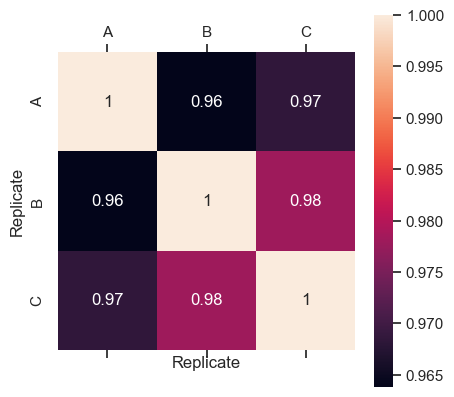

In [36]:
#Correlation condition 1

df_corr = pd.pivot_table(df_r, index=["position","codon","Fragment"], columns= "Replicate", values="select_coef")

colus2 = df_r['Replicate'].unique()
df_corr=df_corr[colus2]

plt.matshow(df_corr.corr())
corr_mat = df_corr.corr()
sns.heatmap(corr_mat, annot=True)

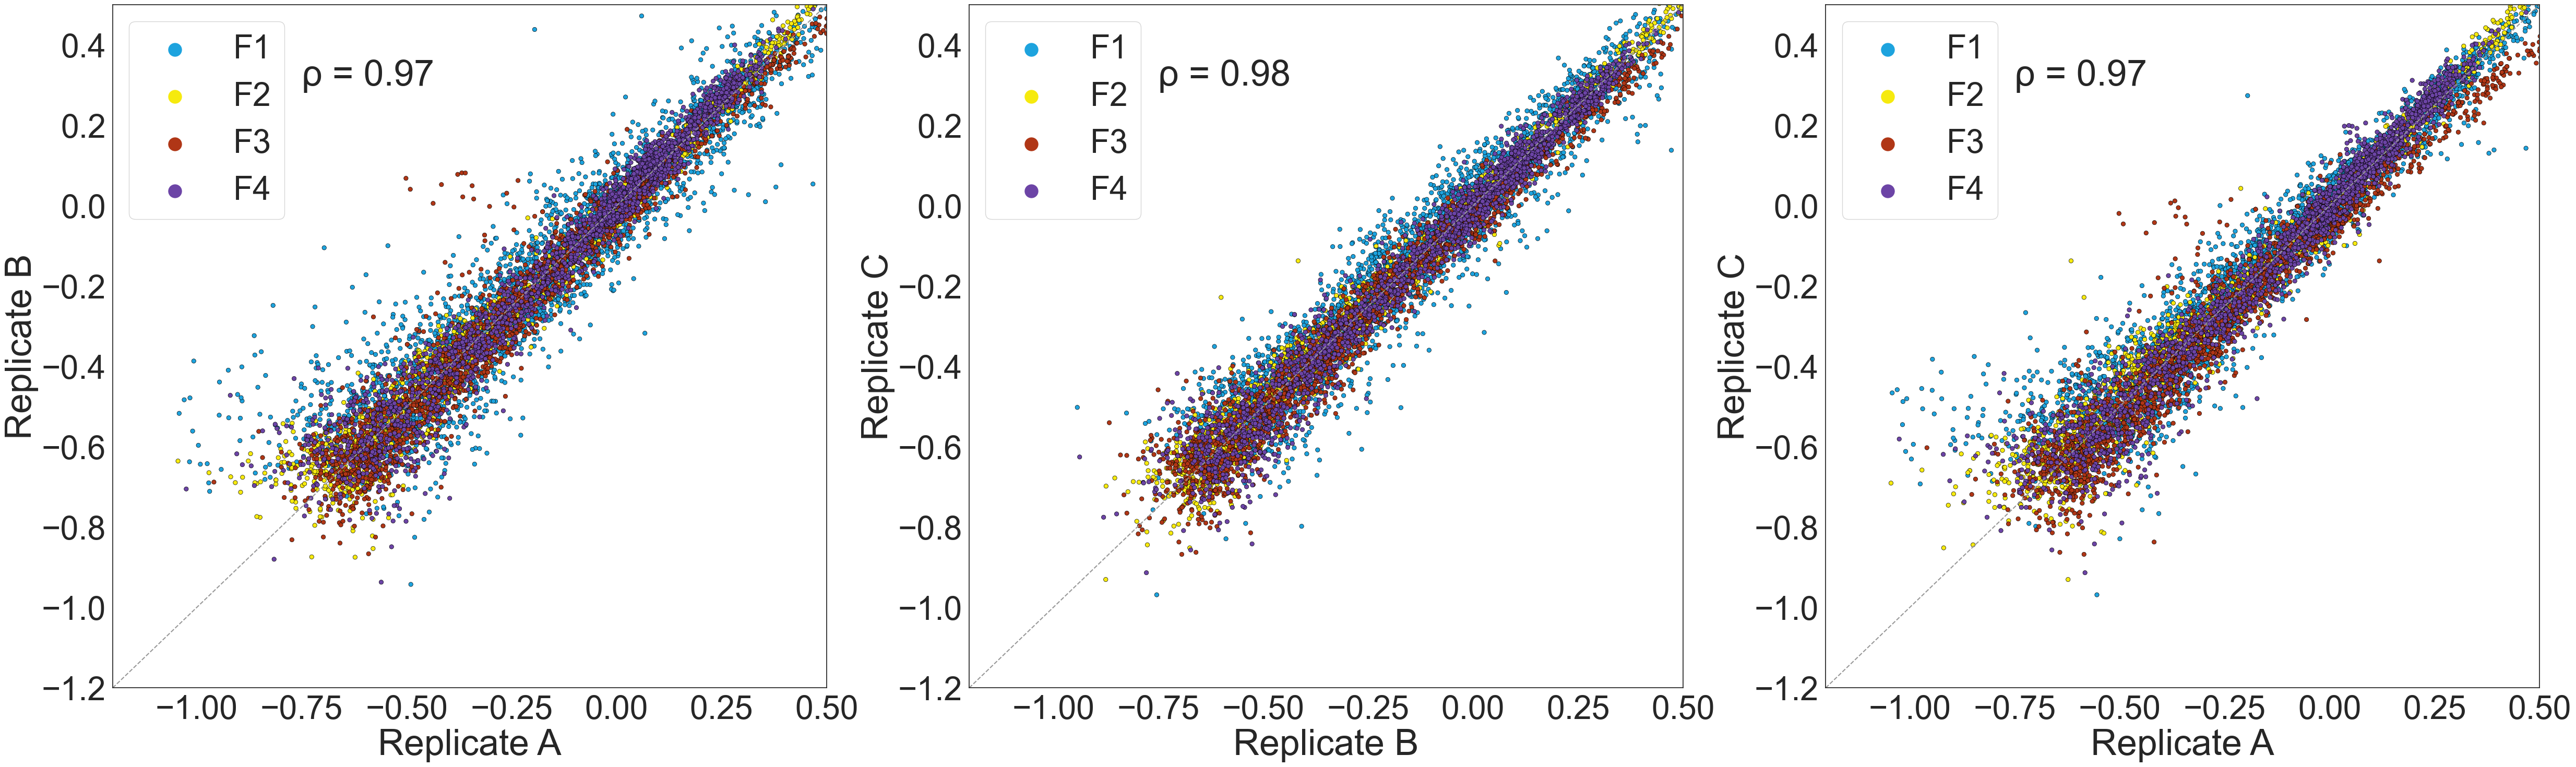

In [37]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")


r_list = ["A","B","A"]


r2_list = ["B","C","C"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(3) :
    
    sns.set_theme(style="white")
    
    colors = ["#1DA3DE","#F6EA0E","#B03616","#6C44A6"]
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
    rep1 = df_r_g.get_group(r_list[i]).reset_index()
    rep2 = df_r_g.get_group(r2_list[i]).reset_index()
    

    
    sns.scatterplot(x=rep1["select_coef"],  y=rep2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = rep1["Fragment"],ax = axes[row])
    
    axes[row].set_ylabel("Replicate " + str(r2_list[i]), fontsize=50)
    axes[row].set_xlabel("Replicate " + str(r_list[i]), fontsize=50)
    
    #title = "Replicate " + str(r_list[i]) + " and Replicate " + str(r2_list[i])
    #axes[row].set_title(title, fontsize=55)
    
    axes[row].set_ylim(-1.2, 0.5)
    axes[row].set_xlim(-1.2, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-1.2, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
    
    result = sp.stats.spearmanr(rep1["select_coef"],rep2["select_coef"])
    coeff = result[0]
    p_value = "{:.1e}".format(result[1])
    R2 = coeff**2     
    
    text = "ρ = " + str(round(coeff,2))
    #+ "\np-value = "  + str(p_value)
    axes[row].text(-0.75,0.3, text , fontsize = 50)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)
#fig.suptitle('Correlation between the Selection coefficient of replicates - ' + condition, y=0.95, fontsize=50)


plt.rcParams['svg.fonttype'] = 'none'
name = "Regression_replicate_select_coeff_" + condition + "_" + experiment + "_" + date
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [38]:
#Get the median of the replicates

df_group = df_r.groupby(["position","codon","Antifungal","Fragment","aa"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","nbr_gen","select_coef"]
df_med = df_group[cols].median()

#reset index so the index becomes columns again
df_med = df_med.reset_index(level=["position","codon","Antifungal","Fragment","aa"])

name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_med.to_csv(name)  
df_med

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA     Clotri       F1  K  0.000103  0.000004 -3.957510   
1           55   AAC     Clotri       F1  N  0.000082  0.000007 -3.862344   
2           55   AAG     Clotri       F1  K  0.000121  0.000005 -5.020960   
3           55   AAT     Clotri       F1  N  0.000075  0.000005 -4.247553   
4           55   ACC     Clotri       F1  T  0.000070  0.000027 -1.444269   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT     Clotri       F4  C  0.000203  0.000139 -0.285393   
7988       511   TTA     Clotri       F4  L  0.000151  0.000065 -1.170985   
7989       511   TTC     Clotri       F4  F  0.000122  0.000718  2.556636   
7990       511   TTG     Clotri       F4  L  0.000182  0.000096 -0.918240   
7991       511   TTT     Clotri       F4  F  0.000152  0.000854  2.511750   

      nbr_tp0  nbr_tp2   nbr_gen  select_coef  
0       508.0     17.0  8.327828    -0.458146  
1       406.0     28.0  8.327828    -0.370404  
2       598.0     18.0  8.327828    -0.432688  
3       370.0     16.0  8.327828    -0.395233  
4       328.0     92.0  8.327828    -0.058616  
...       ...      ...       ...          ...  
7987    718.0    502.0  8.644147     0.033840  
7988    532.0    228.0  8.644147    -0.026699  
7989    431.0   2194.0  8.644147     0.371550  
7990    644.0    290.0  8.644147    -0.021810  
7991    537.0   2576.0  8.644147     0.363786  

[7992 rows x 12 columns]

# 5- Control between codons

In [39]:
name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_c = pd.read_csv(name, header=0, index_col = 0)
df_c

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA     Clotri       F1  K  0.000103  0.000004 -3.957510   
1           55   AAC     Clotri       F1  N  0.000082  0.000007 -3.862344   
2           55   AAG     Clotri       F1  K  0.000121  0.000005 -5.020960   
3           55   AAT     Clotri       F1  N  0.000075  0.000005 -4.247553   
4           55   ACC     Clotri       F1  T  0.000070  0.000027 -1.444269   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT     Clotri       F4  C  0.000203  0.000139 -0.285393   
7988       511   TTA     Clotri       F4  L  0.000151  0.000065 -1.170985   
7989       511   TTC     Clotri       F4  F  0.000122  0.000718  2.556636   
7990       511   TTG     Clotri       F4  L  0.000182  0.000096 -0.918240   
7991       511   TTT     Clotri       F4  F  0.000152  0.000854  2.511750   

      nbr_tp0  nbr_tp2   nbr_gen  select_coef  
0       508.0     17.0  8.327828    -0.458146  
1       406.0     28.0  8.327828    -0.370404  
2       598.0     18.0  8.327828    -0.432688  
3       370.0     16.0  8.327828    -0.395233  
4       328.0     92.0  8.327828    -0.058616  
...       ...      ...       ...          ...  
7987    718.0    502.0  8.644147     0.033840  
7988    532.0    228.0  8.644147    -0.026699  
7989    431.0   2194.0  8.644147     0.371550  
7990    644.0    290.0  8.644147    -0.021810  
7991    537.0   2576.0  8.644147     0.363786  

[7992 rows x 12 columns]

In [40]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in df_c.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
df_c["aa"] = aa_list

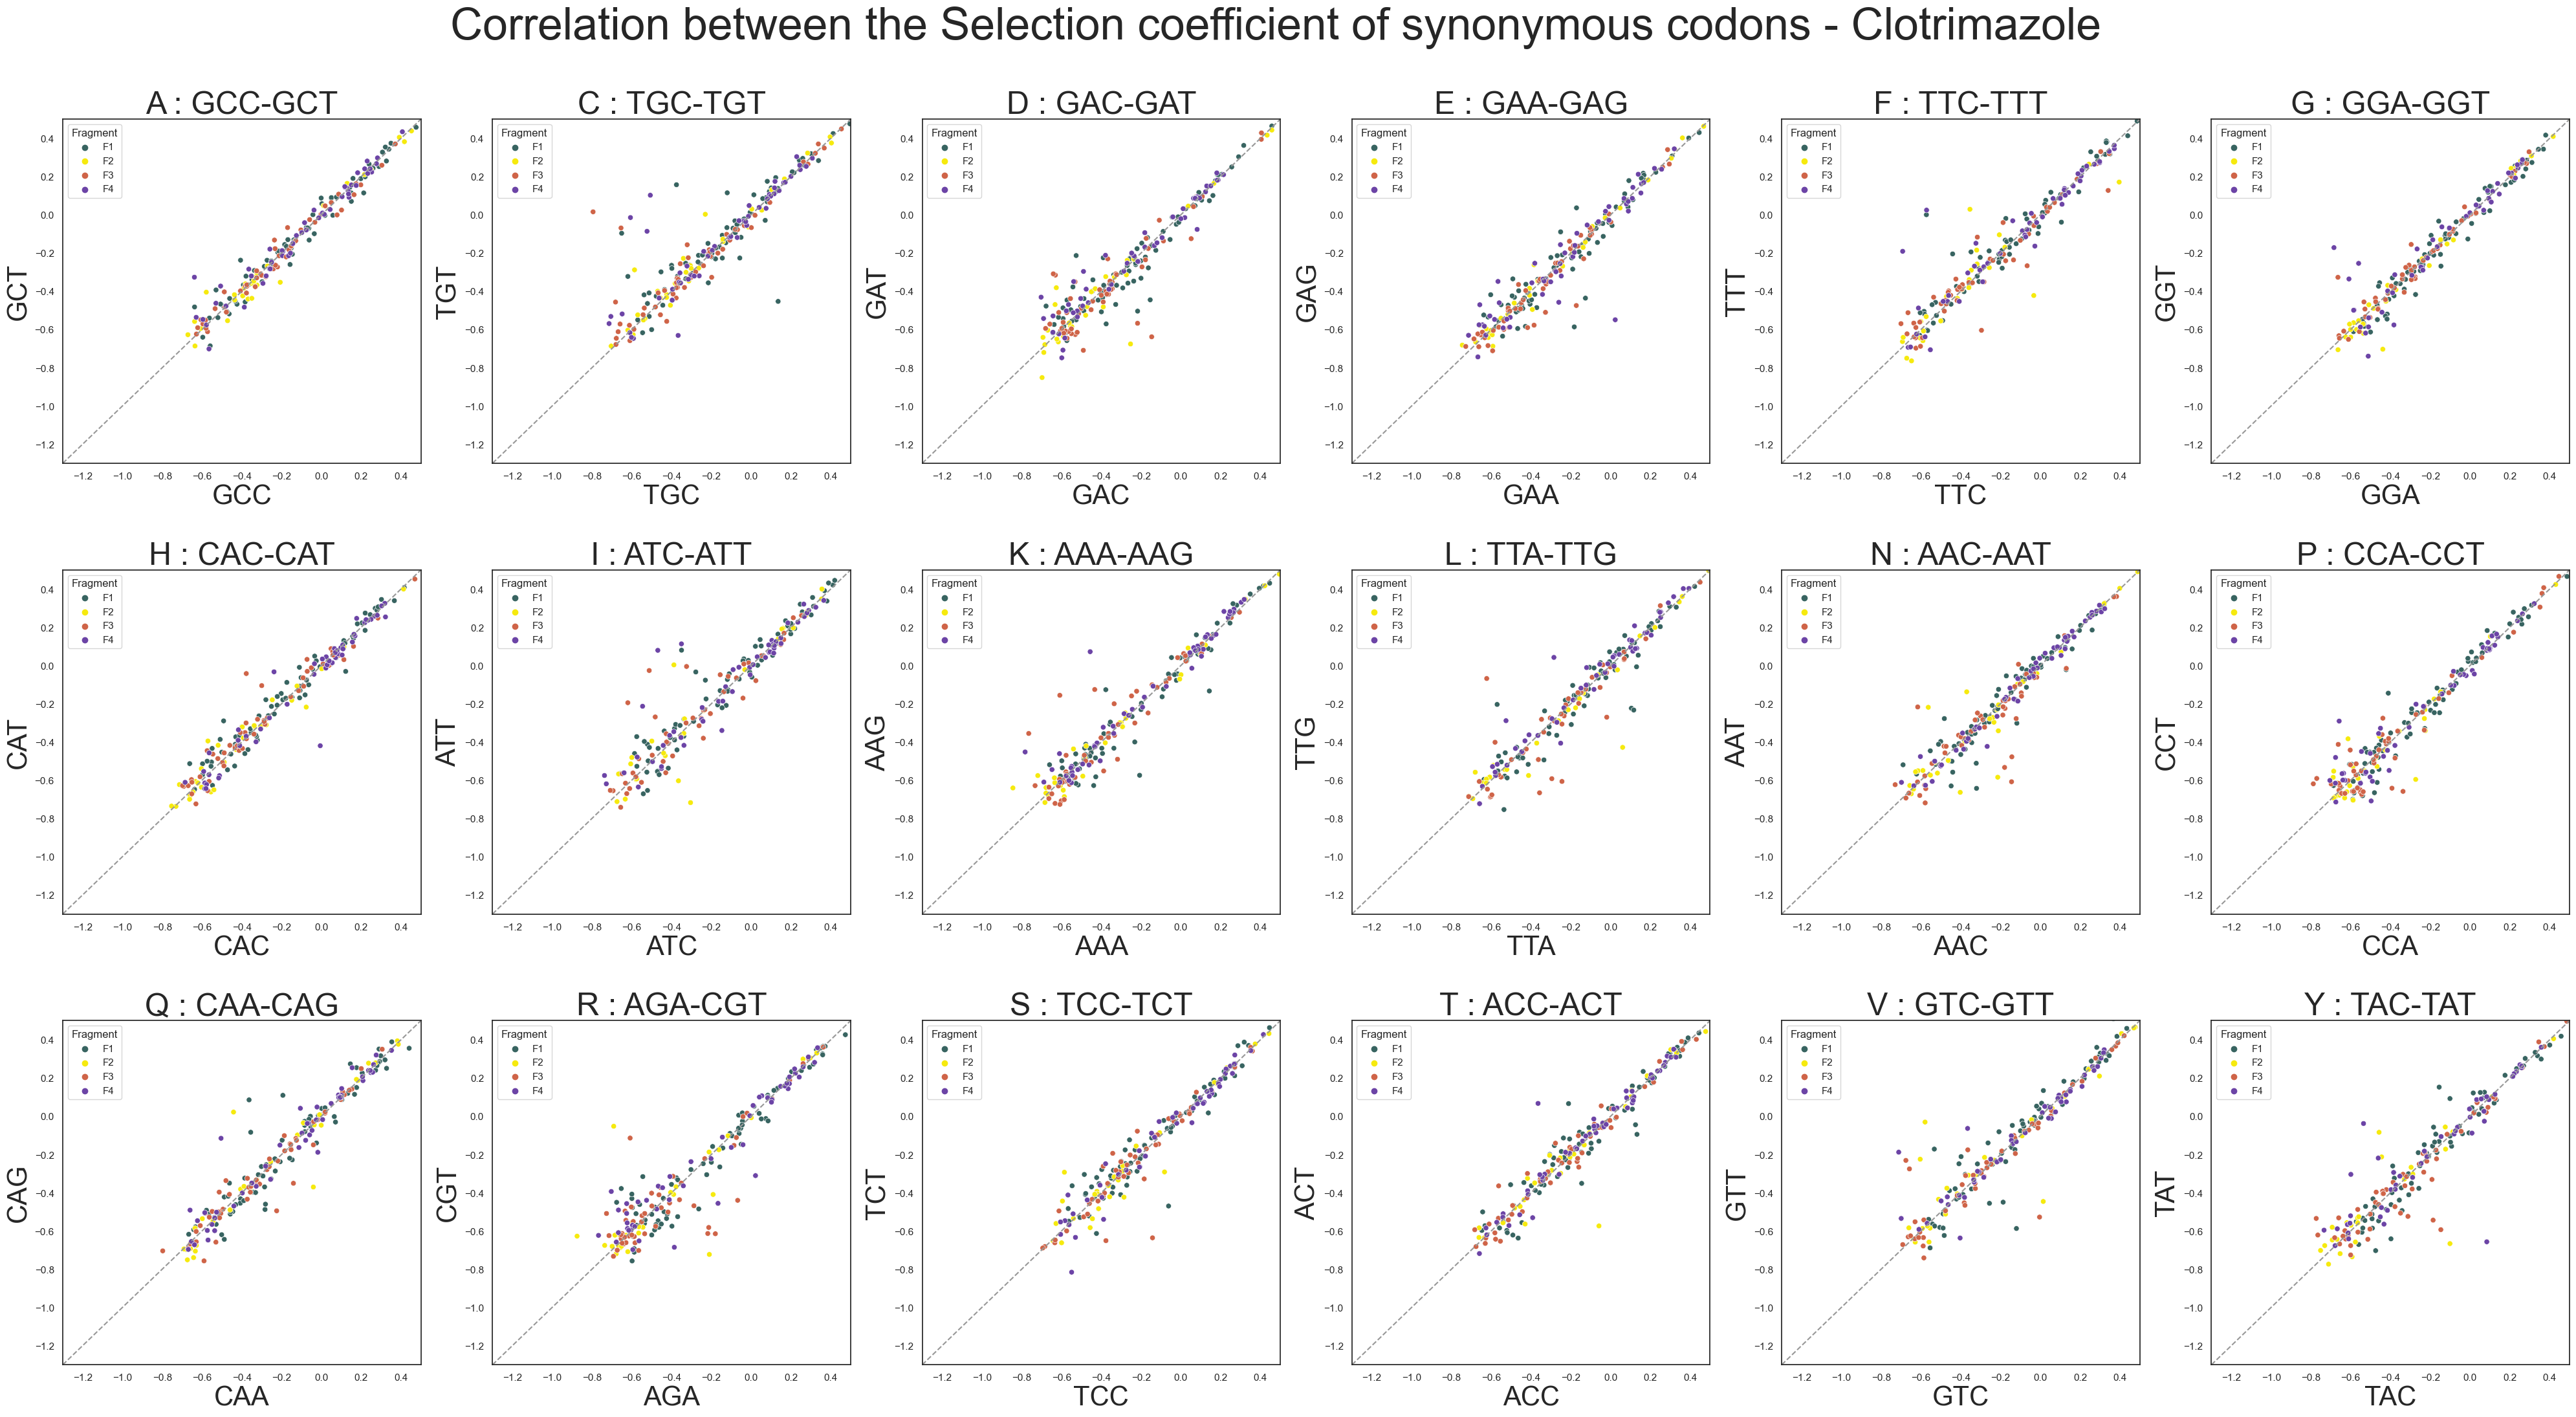

In [41]:
df_co = df_c

# remove wt as they often have only one codon

ite = 0  # Initializing a counter variable

for i in df_co.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_co.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] == aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_co = df_co.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable

df_cod = df_co.groupby(["codon"])
df_aa = df_co.groupby(["aa"])

syn_list = ["A","C","D","E","F","G","H","I","K","L","N","P","Q","R","S","T","V",'Y']

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(3, 6, figsize=(50,25))
axes = axes.flatten()
    
for aa in syn_list :
    
    sns.set_theme(style="white")
    
    colors = ["#386461","#F6EA0E","#CF6448","#6C44A6"]
    sns.set_palette(sns.color_palette(colors))
    
    amac = df_aa.get_group(aa)
    
    codons = amac['codon'].unique()
    
    cod1 = codons[0]
    cod2 = codons[1]

    cod_df = amac.groupby("codon")
    
    codon1 = cod_df.get_group(cod1).reset_index()
    codon2 = cod_df.get_group(cod2).reset_index()
    
    sns.scatterplot(x = codon1["select_coef"], y = codon2["select_coef"], legend = True, hue = codon1["Fragment"],ax = axes[row])
    axes[row].set_ylabel(cod2, fontsize=30)
    axes[row].set_xlabel(cod1, fontsize=30)
    title = aa + " : " + cod1 + "-" + cod2
    axes[row].set_title(title, fontsize=35)
    axes[row].set_ylim(-1.3, 0.5)
    axes[row].set_xlim(-1.3, 0.5)
    
    x_vals = np.array([-1.3, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")

    row +=1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Correlation between the Selection coefficient of synonymous codons - ' + condition, y=0.95, fontsize=50)

name = "Correlation_between_synonymous_codons_" + "select_coeff_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [47]:
# get the mean of every codon

df_group = df_c.groupby(["position","aa","Antifungal","Fragment"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal","Fragment"])

name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name)  

# 6- Control between overlaps

#### We want to verify if the correlation between our overlap is good to see if our results are reproducible and constant.

In [48]:
name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_o = pd.read_csv(name, header=0, index_col = 0)

In [49]:
df_o

position aa Antifungal Fragment  freq_tp0  freq_tp2  l2fc_0_2  nbr_tp0  \
0           55  *     Clotri       F1  0.000109  0.000004 -5.122875    539.0   
1           55  A     Clotri       F1  0.000092  0.000037 -1.795674    457.0   
2           55  C     Clotri       F1  0.000115  0.000039 -1.717607    566.5   
3           55  D     Clotri       F1  0.000100  0.000003 -4.684300    496.5   
4           55  E     Clotri       F1  0.000138  0.000009 -4.172895    682.0   
...        ... ..        ...      ...       ...       ...       ...      ...   
4277       511  S     Clotri       F4  0.000155  0.000141 -0.215449    549.0   
4278       511  T     Clotri       F4  0.000156  0.000043 -1.784217    550.0   
4279       511  V     Clotri       F4  0.000115  0.000091 -0.103918    406.0   
4280       511  W     Clotri       F4  0.000153  0.000181  0.414998    540.0   
4281       511  Y     Clotri       F4  0.000139  0.000011 -3.325914    490.0   

      nbr_tp2  select_coef  
0        14.0    -0.500341  
1       136.5    -0.067066  
2       159.0    -0.080726  
3        11.5    -0.537737  
4        33.5    -0.429640  
...       ...          ...  
4277    457.0     0.074396  
4278    136.0    -0.135075  
4279    324.5     0.049627  
4280    614.0     0.093816  
4281     33.5    -0.333101  

[4282 rows x 10 columns]

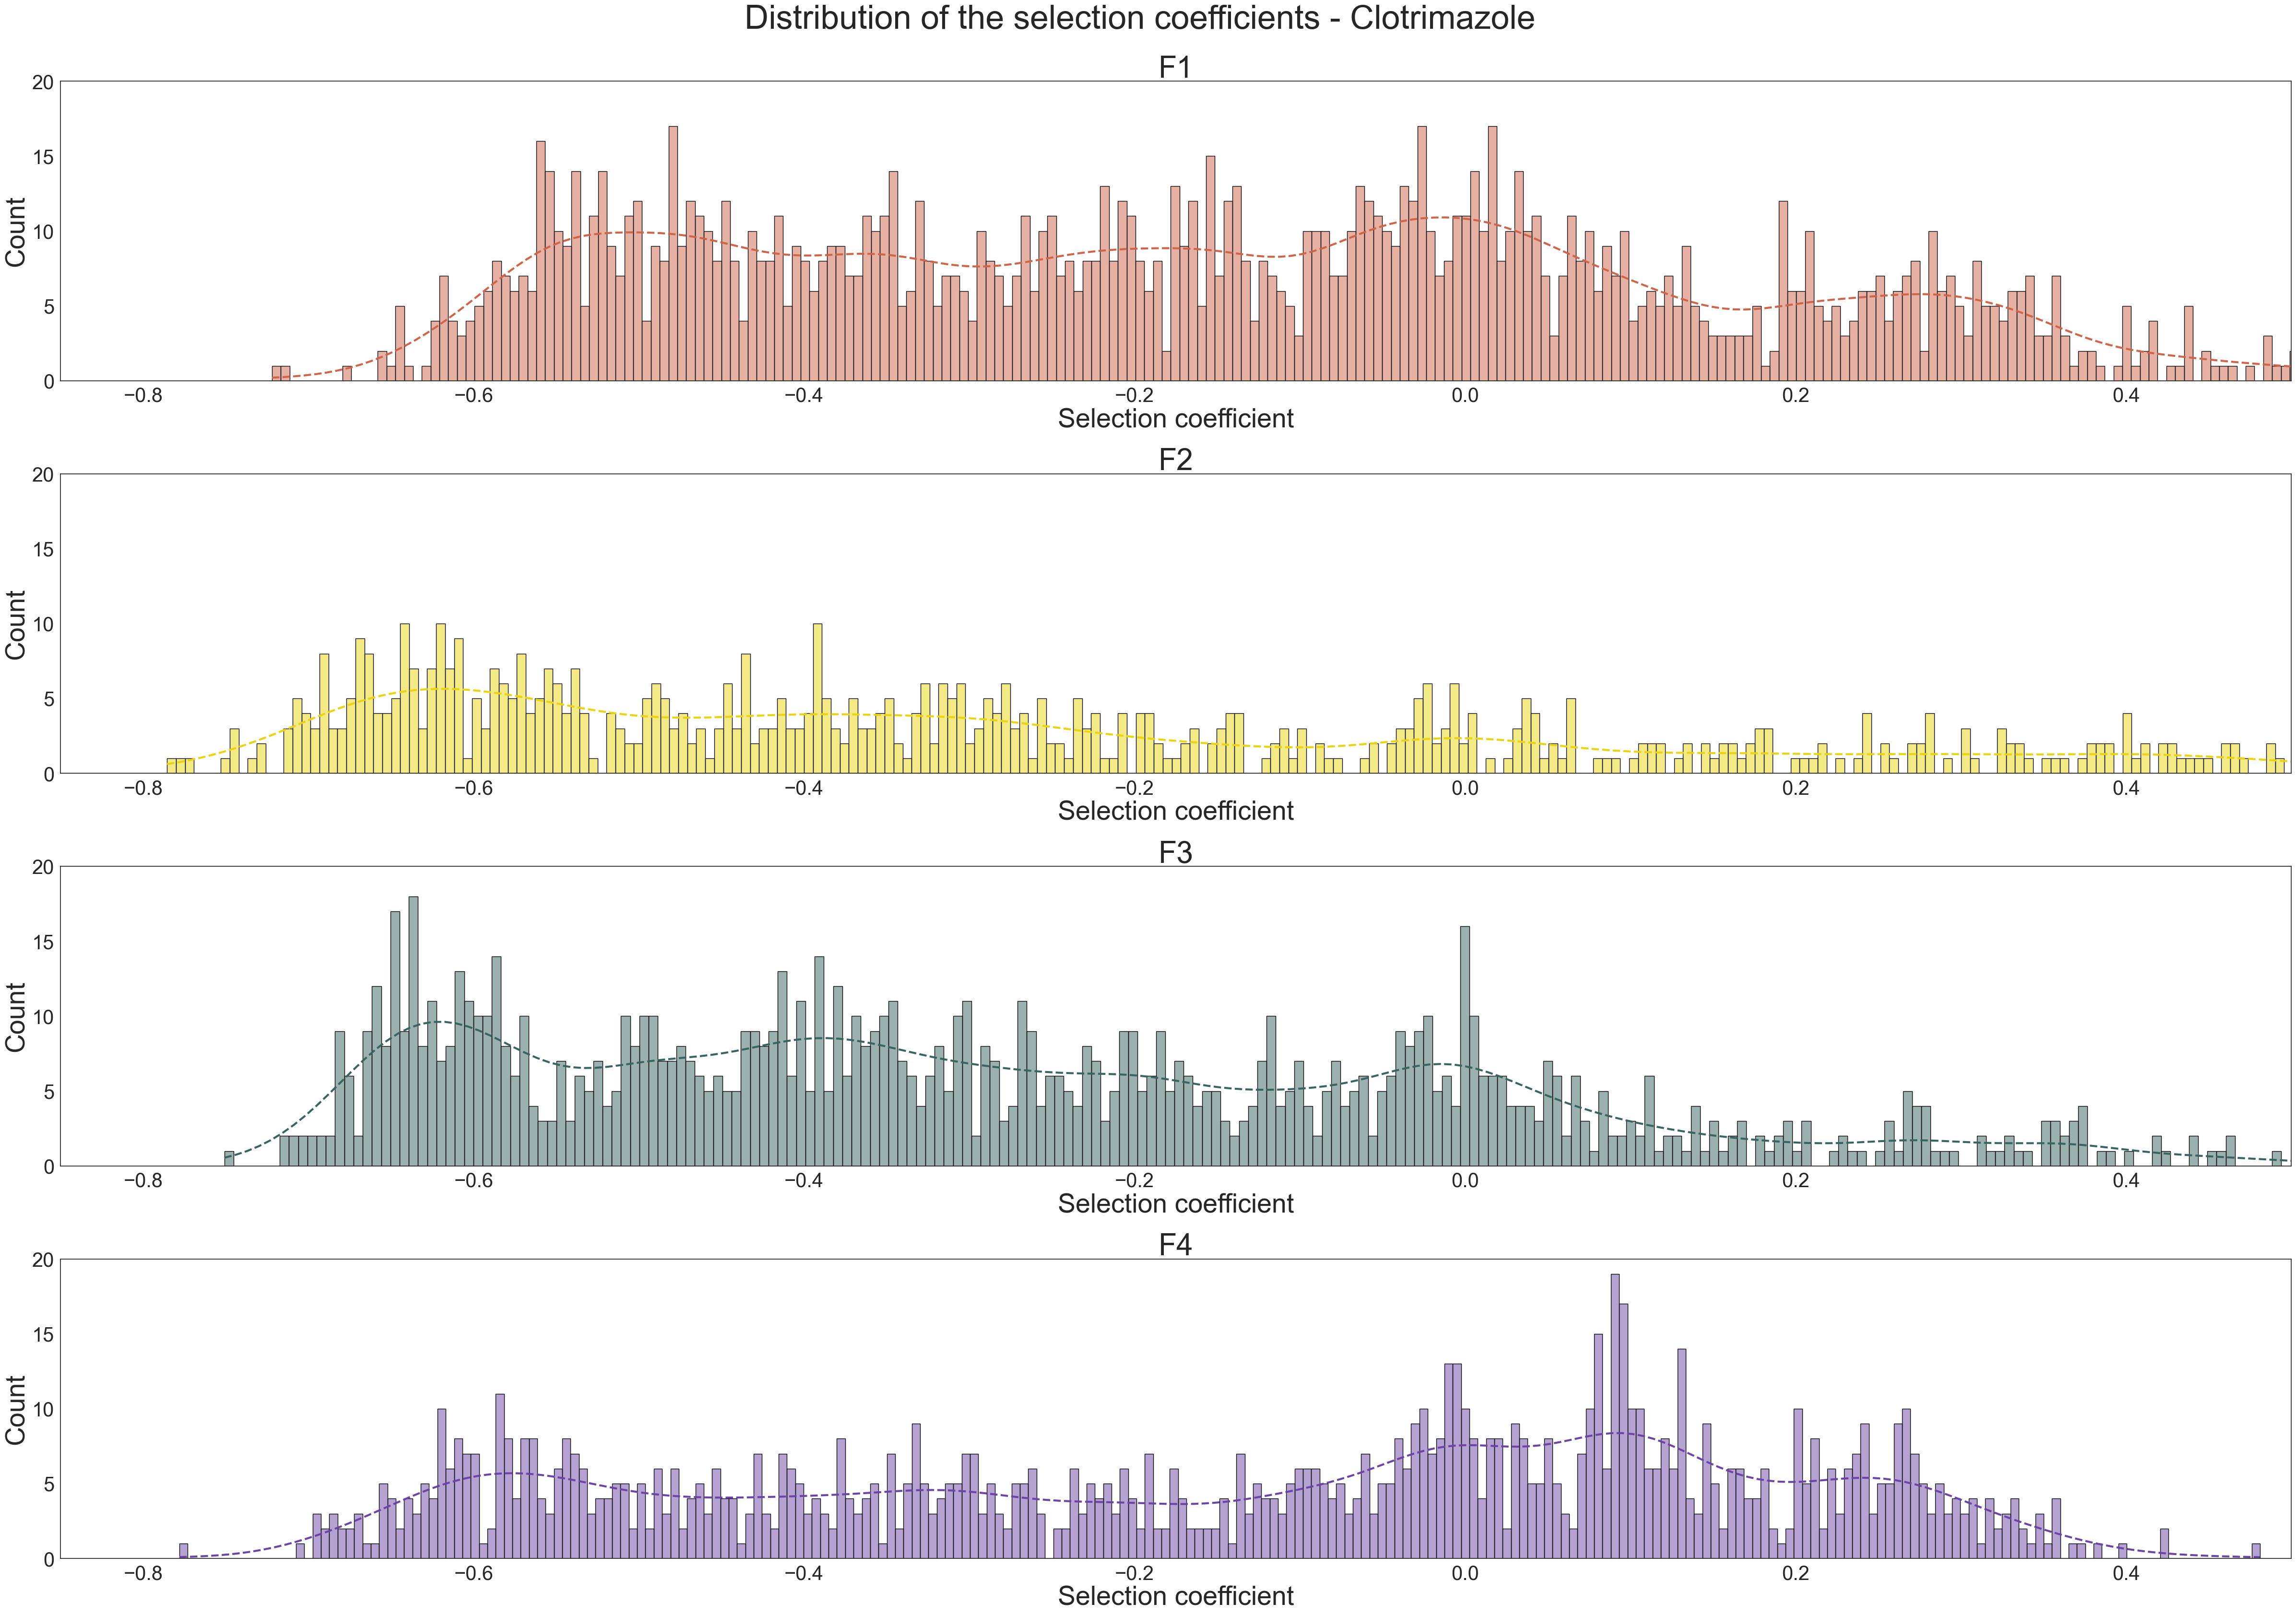

In [52]:
#Distribution of the selection coefficient

df_o_F = df_o.groupby("Fragment")

f_list = ["F1","F2","F3","F4"]
color_list = ["#CF6448","#E9D40D","#386461","#6C44A6"]
row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(4, 1, figsize=(60,40))
axes = axes.flatten()
 
for frag in f_list :
    
    df = df_o_F.get_group(frag)
    
    sns.set_theme(style="white")
    
    sns.histplot(x=df["select_coef"], edgecolor="black", color = color_list[row],  bins = 250,kde=True, kde_kws = {'bw_adjust': 0.5},ax = axes[row], 
                 line_kws = {'linestyle':'dashed','linewidth':'3'}).lines[0].set_color(color_list[row])

    axes[row].set_ylim(0, 20)
    axes[row].set_xlim(-0.85, 0.5)
    
    axes[row].set_ylabel("Count",fontsize=40)
    axes[row].set_xlabel("Selection coefficient",fontsize=40)
    
    axes[row].set_title(frag, fontsize=45)
    
    axes[row].tick_params(labelsize = 30)  
    
    row += 1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Distribution of the selection coefficients - ' + condition, y=0.92, fontsize=50)

name = "Distribution_of_the_selection_coefficient_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [53]:
#put rows in overlaps in a new df

df_new = pd.DataFrame(columns=["index", 'position', 'aa', 'Antifungal', 'Fragment', "l2fc_0_2", "l2fc_0_3", "select_coef", "l2fc_0_2_norm", "l2fc_0_3_norm", "select_coef_norm"])

for _, row in df_o.iterrows():
    position = row['position']
    fragment = row['Fragment']
    
    if position in f3_f4_over and fragment == "F3":
        row['Fragment'] = "F3_4"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F2":
        row['Fragment'] = "F2_3"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F3":
        row['Fragment'] = "F3_2"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f1_f2_over and fragment == "F2":
        row['Fragment'] = "F2_1"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in over_list:
        df_new = df_new.append(row, ignore_index=True)
        
df_new = df_new.reset_index().drop("index",axis=1).drop("level_0",axis=1)

C:\Users\CABED117\AppData\Local\Temp\ipykernel_8184\2685448605.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_8184\2685448605.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_8184\2685448605.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_8184\2685448605.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_inde

In [54]:
df_group = df_new.groupby(["Fragment"])

f1 = df_group.get_group("F1").reset_index()
f2_1 = df_group.get_group("F2_1").reset_index()
f2_3 = df_group.get_group("F2_3").reset_index()
f3_2 = df_group.get_group("F3_2").reset_index()
f3_4 = df_group.get_group("F3_4").reset_index()
f4 = df_group.get_group("F4").reset_index()

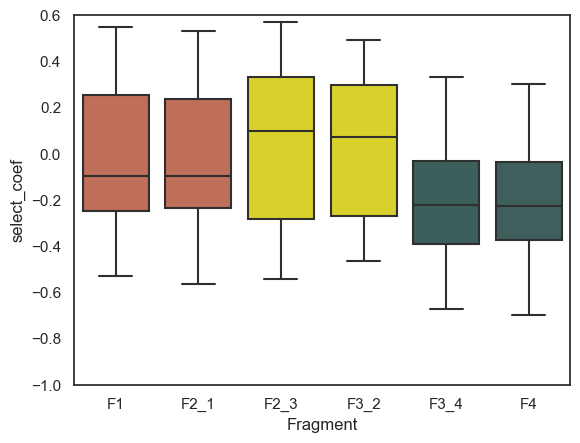

In [55]:
sns.set_theme(style="white")

custom_palette = sns.blend_palette(["#CF6448","#CF6448","#F6EA0E","#F6EA0E","#386461","#386461"], n_colors=6)
sns.boxplot(data= df_new, x= "Fragment", y = "select_coef", palette = custom_palette)
plt.ylim(-1, 0.6)

name = "Boxplot_overlaps_med_select_coef_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

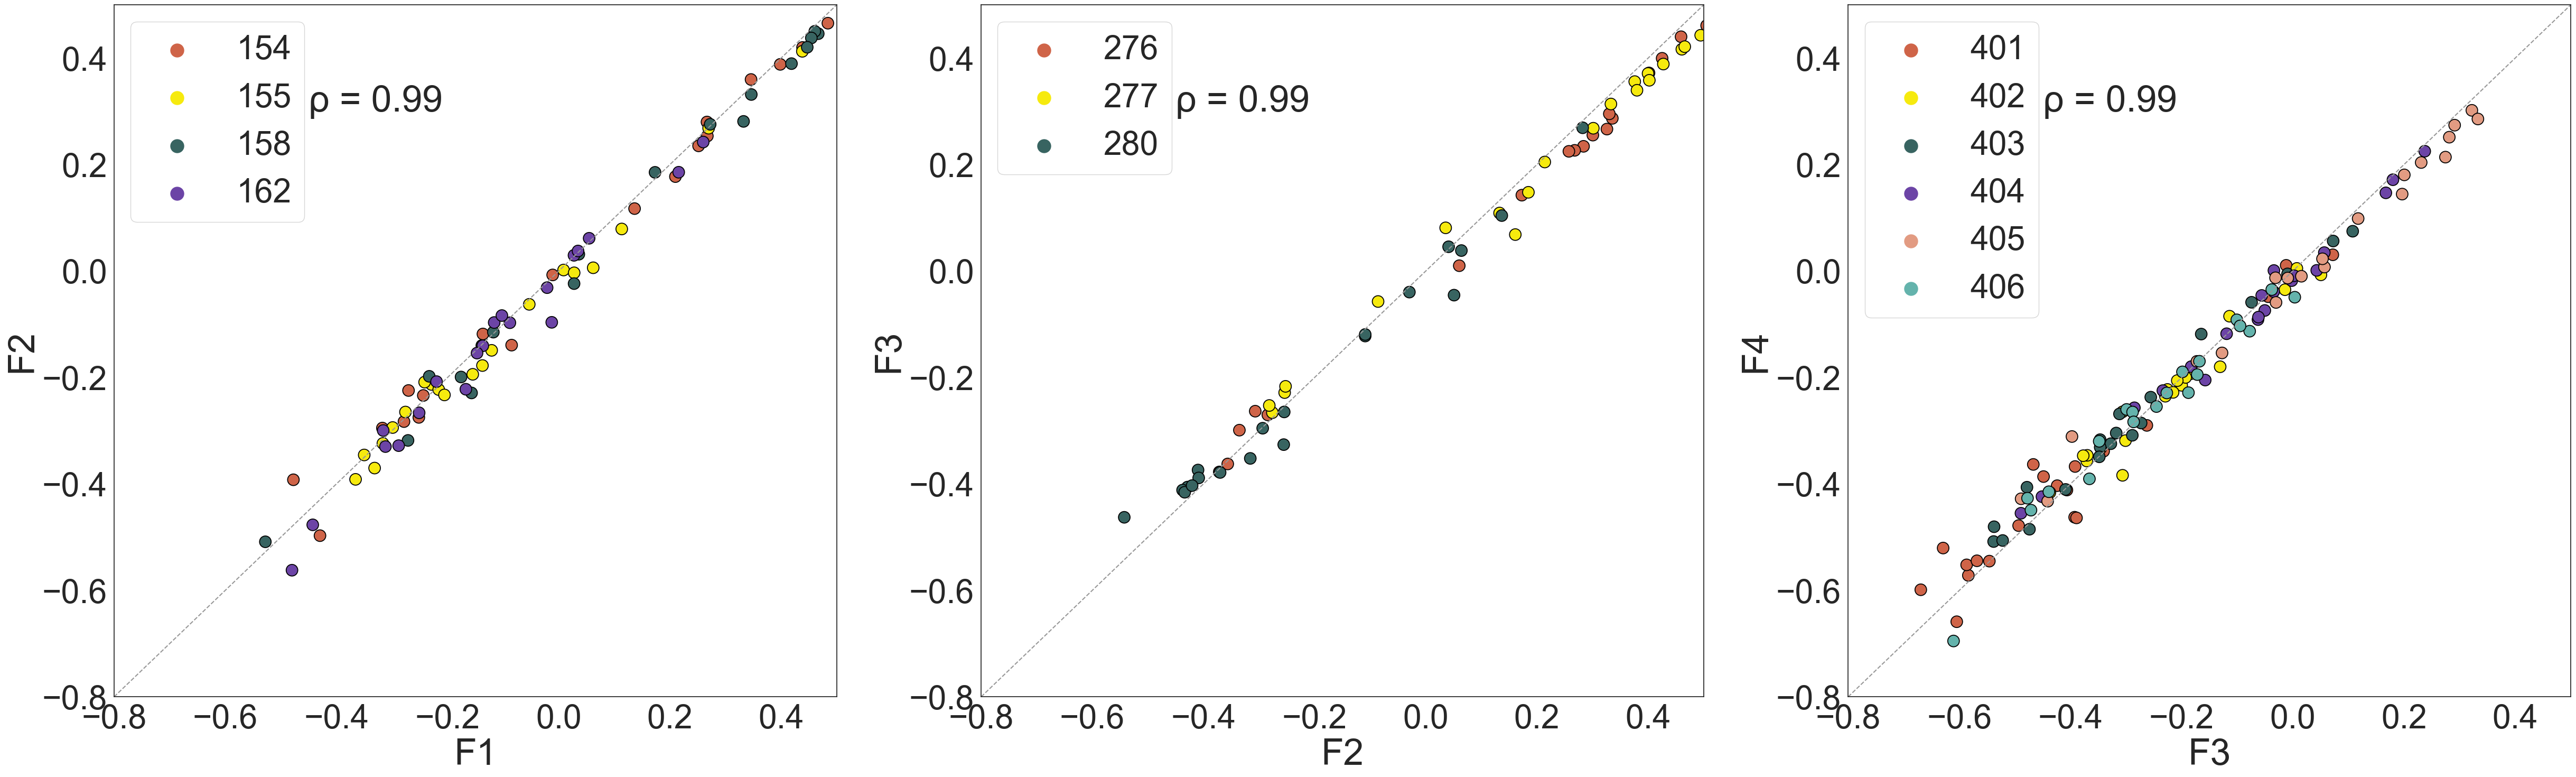

In [56]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")

o1_list = ["f1","f2_3","f3_4"]

o2_list = ["f2_1","f3_2","f4"]

title_name = ["F1 and F2","F2 and F3","F3 and F4"]
x_name = ["F1", "F2", "F3"]
y_name = ["F2", "F3", "F4"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(len(o1_list)) :
    
    name1 = o1_list[i]
    df1 = globals()[name1]
    
    name2 = o2_list[i]
    df2 = globals()[name2]
    
    sns.set_theme(style="white")
    
    custom_palette = sns.color_palette(["#CF6448","#F6EA0E","#386461","#6C44A6","#E29B82","#64B3AC"], n_colors=len(df1["position"].unique()))
    
    sns.scatterplot(x=df1["select_coef"],  y=df2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = df1["position"],s = 250, ax = axes[row])    
    
    axes[row].set_ylabel(y_name[i], fontsize=50)
    axes[row].set_xlabel(x_name[i], fontsize=50)
    
    #axes[row].set_title(title_name[i], fontsize=55)
    
    axes[row].set_ylim(-0.8, 0.5)
    axes[row].set_xlim(-0.8, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-0.8, 0.5])
    y_vals = x_vals
    
    result = sp.stats.spearmanr(df1["select_coef"],df2["select_coef"])
    coeff = result[0]
    p_value = result[1]
    R2 = coeff**2 
    
    text = "ρ = " + str(round(coeff, 2)) #+ "\nP = " + str(round(p_value, 5))
    axes[row].text(-0.45,0.3, text , fontsize = 50)

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)



plt.rcParams['svg.fonttype'] = 'none'
name = "Overlap_select_coef_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [57]:
#Getting the means of the overlapping positions

#norm_df = norm_df.drop('Fragment', axis=1)

df_group = df_o.groupby(["position","aa","Antifungal"])
cols = ["select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal"])

name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name) 

# 7- Heatmaps and figures !!

In [58]:
name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_f = pd.read_csv(name, header=0, index_col = 0)

In [59]:
WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0, index_col = 0)

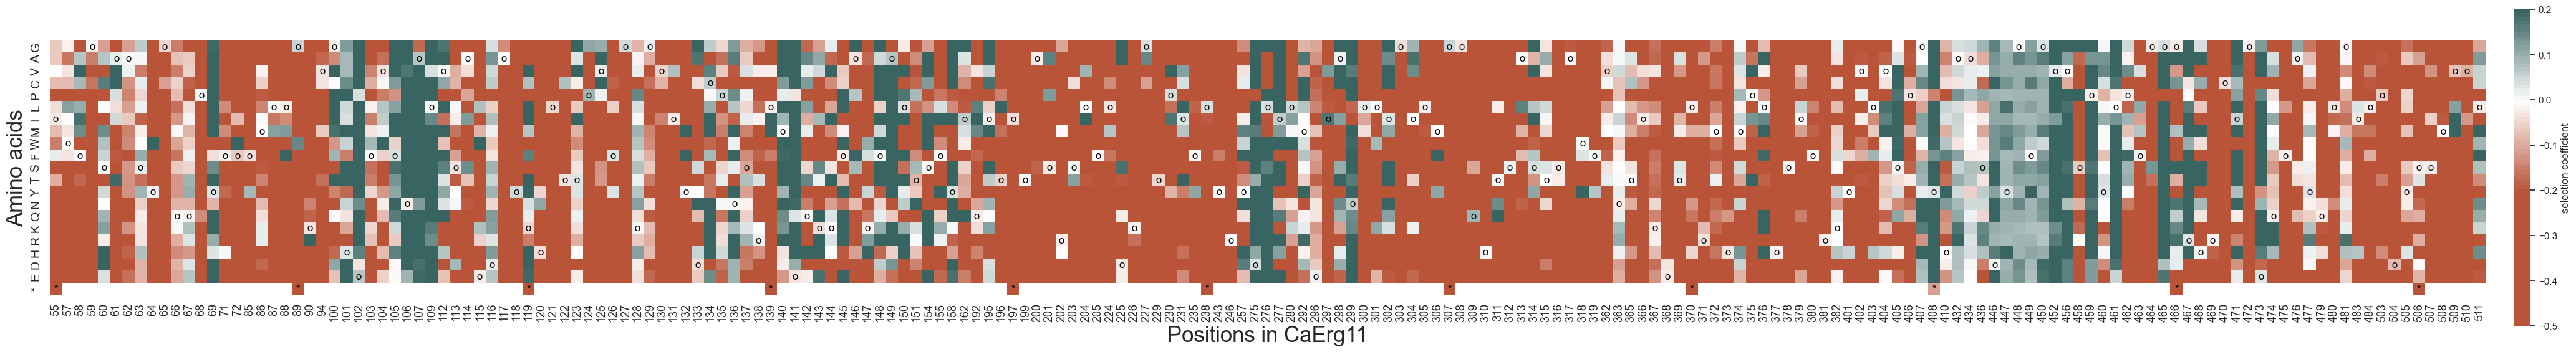

In [60]:
heat = pd.pivot_table(df_f, index="aa", columns= "position", values="select_coef")

heat = heat.reindex(index = ["G","A","V","C","P","L","I","M","W","F","S","T","Y","N","Q","K","R","H","D","E","*"])

custom_palette = sns.blend_palette(["#B95439","#B95439","#B95439","#FFFFFF","#386461"], n_colors=101)

plt.subplots(figsize=(60,60))
sns.set(rc={'figure.facecolor':'white'})
#sns.set(font_scale=1.5)

sns.heatmap(heat, xticklabels="auto", yticklabels=True, annot=False, cmap = custom_palette, 
            robust = True,square=True,  vmin=-0.5, vmax=0.2,center=-0.2, 
            cbar_kws={"shrink": 0.11,"pad": 0.01,'label': 'selection coefficient'})

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=13)

for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if WT_annot.iloc[i, j] == "o" or WT_annot.iloc[i, j] == "*":
            plt.text(j + 0.5, i + 0.5, WT_annot.iloc[i, j], ha='center', va='center', fontsize=12, color='black')
        
#titre = f"Selection coefficients - {condition} Screening - Library Erg11 of " + '$\it{Candida}$' +" "+ '$\it{albicans}$'

#plt.title(titre, fontsize =30)

plt.xlabel('Positions in CaErg11', fontsize = 25)
plt.ylabel('Amino acids', fontsize = 25)

plt.rcParams['svg.fonttype'] = 'none'
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".png"
plt.savefig(name, transparent=True, dpi=750,format='png', bbox_inches='tight')
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".svg"
plt.savefig(name, transparent=True, dpi=300,format='svg', bbox_inches='tight')

# 8- t-test significant resistance

In [61]:
#import the df with the replicates, replicates are needed for t tests
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"

df_t = pd.read_csv(name, header=0)

In [62]:
# Add a new column with the translation
df_t['aa'] = df_t['codon'].map(DNA_Codons)
df_t['DNA_variant'] =df_t['position'].astype(str) + df_t['codon']
df_t['aa_variant'] =df_t['position'].astype(str) + df_t['aa']

In [63]:
Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [64]:
# get all the wts infos in our df 

df_wt = df_t  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    else :   
        df_t.loc[ite,"aa_variant"] = "WT"
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.drop("level_0",axis=1).reset_index()

In [65]:
# Perform t-tests for each variant
variants = df_t['aa_variant'].unique()
results = []

for variant in variants:
    variant_data = df_t[df_t['aa_variant'] == variant]

    anti_data = variant_data[variant_data['Antifungal'] == cond]['select_coef']
    wt_data = df_t[df_t['aa_variant'] == 'WT']['select_coef']
    t_stat, p_value = ttest_ind(anti_data, wt_data)
    
    results.append((variant, p_value))

# Apply FDR correction to the p-values decause I am doing multiple comparaison
_, adjusted_p_values, _, _ = multipletests([p_value for _, p_value in results], method='fdr_bh')

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['aa_variant', 'p_value'])
results_df['adjusted_p_value'] = adjusted_p_values

# View the results
print(results_df)

     aa_variant       p_value  adjusted_p_value
0           55K  3.276578e-83      1.079327e-82
1           55N  1.171614e-63      2.929799e-63
2           55T  4.059805e-09      5.158578e-09
3           55R  3.137411e-86      1.091682e-85
4            WT  1.000000e+00      1.000000e+00
...         ...           ...               ...
3826       511Y  2.443534e-53      5.324902e-53
3827       511S  1.990360e-04      2.296708e-04
3828       511C  8.886254e-03      9.782540e-03
3829       511W  1.020725e-03      1.153510e-03
3830       511F  2.836536e-64      7.144489e-64

[3831 rows x 3 columns]


In [66]:
# Merge the variant results 
anti_merged = df_t.merge(results_df, on=['aa_variant'], how='left')

In [67]:
df_group = anti_merged.groupby(["position","Antifungal","aa"])
cols = ["select_coef","p_value","adjusted_p_value"]
med_anti = df_group[cols].median()

#reset index so the index becomes columns again
med_anti = med_anti.reset_index(level=["position","Antifungal","aa"])
med_anti['aa_variant'] =med_anti['position'].astype(str) + med_anti['aa']

In [68]:
advantageous = []
wt_like = []
deleterious = []
df_del = pd.DataFrame(columns=['select_coef', 'aa_variant', 'result'])

for i in range(len(med_anti)):
    if med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] > 0:
        advantageous.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Advantageous"
    elif med_anti.loc[i,"adjusted_p_value"] > 0.01 :
        wt_like.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "WT like"
    elif med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] < 0:
        deleterious.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Deleterious"

In [69]:
print(str(len(advantageous)) + " variant have an advantage")
print(str(len(deleterious)) + " variant have a deleterious substitution")
print(str(len(wt_like)) + " variant are like the WT without antifungal")

882 variant have an advantage
2598 variant have a deleterious substitution
542 variant are like the WT without antifungal


In [70]:
df_del_g = df_del.groupby("result")
df_del_wt = df_del_g.get_group("WT like")
#df_del_wt["select_coef"].max()
#df_del_wt["select_coef"].min()
df_del_wt["select_coef"].quantile(0.05)
#df_del_wt["select_coef"].quantile(0.05)

-0.04998392021023855

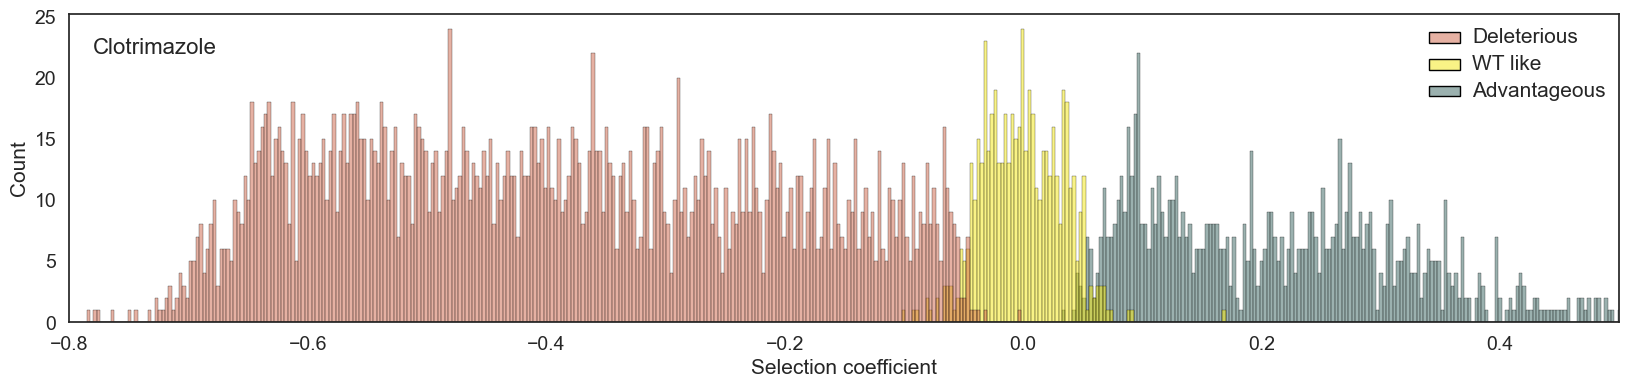

In [71]:
sns.set_style("white")
sns.set_theme(style="white", palette=None)

plt.subplots(figsize=(20, 4))
custom_palette = sns.blend_palette(["#CF6448", "#F6EA0E", "#386461"], n_colors=3)

plot = sns.histplot(data=df_del, x="select_coef", edgecolor="black", hue="result", palette=custom_palette, bins=500)

legend = plot.get_legend()  
legend.set_title("", prop={"size": 16} ) 
legend.set_frame_on(False)
for label in legend.get_texts():  
    label.set_size(15)  
    
plt.xlim(-0.8, 0.5)
#plt.title(condition + " - distribution of the selection coefficient", fontsize=20)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)

plt.xlabel('Selection coefficient', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

plt.text(-0.78,22, condition , fontsize = 16)
    
plt.rcParams['svg.fonttype'] = 'none'
name = "Distribution_" + "select_coef_t-test_results_" + condition + "_" +experiment + "_" + date 
plt.savefig(name+ ".png", transparent=True, dpi=750,format='png', bbox_inches='tight')
plt.savefig(name+ ".svg", transparent=True, dpi=750,format='svg', bbox_inches='tight')

In [73]:
#med_anti = med_anti.drop(["level_0","index"], axis=1)
med_anti = med_anti.rename(columns={"aa_variant": "variant"})
name = "Select_coeff_p_value_aa_" + condition + "_" + experiment + "_" + date + ".csv"
med_anti.to_csv(name) 

med_anti

position Antifungal aa  select_coef        p_value  adjusted_p_value  \
0           55     Clotri  *    -0.500341   1.138787e-54      2.518875e-54   
1           55     Clotri  A    -0.067066   1.907171e-04      2.204699e-04   
2           55     Clotri  C    -0.080726   8.388161e-05      9.773432e-05   
3           55     Clotri  D    -0.537737  2.129403e-107     1.062206e-106   
4           55     Clotri  E    -0.407222   4.532522e-75      1.341893e-74   
...        ...        ... ..          ...            ...               ...   
4017       511     Clotri  S     0.075024   1.990360e-04      2.296708e-04   
4018       511     Clotri  T    -0.135075   1.193329e-12      1.606904e-12   
4019       511     Clotri  V     0.058365   9.611839e-03      1.057220e-02   
4020       511     Clotri  W     0.093816   1.020725e-03      1.153510e-03   
4021       511     Clotri  Y    -0.348328   2.443534e-53      5.324902e-53   

     variant  
0        55*  
1        55A  
2        55C  
3        55D  
4        55E  
...      ...  
4017    511S  
4018    511T  
4019    511V  
4020    511W  
4021    511Y  

[4022 rows x 7 columns]